<a href="https://colab.research.google.com/github/LuisFTacla/WDW_Attendance_Calculator/blob/main/Calculadora_WDW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color=green>IMPORTANDO BIBLIOTECAS</font>
***

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta

# <font color=green>ANALISANDO TODAS AS ATRAÇÕES DISPONÍVEIS</font>
***

## <font color=green>Lendo os arquivos .csv</font>
***

In [2]:
mk_01 = pd.read_csv('splash_mountain.csv')
mk_02 = pd.read_csv('pirates_of_caribbean.csv')
mk_03 = pd.read_csv('7_dwarfs_train.csv')

ep_01 = pd.read_csv('soarin.csv')
ep_02 = pd.read_csv('spaceship_earth.csv')

hs_01 = pd.read_csv('rock_n_rollercoaster.csv')
hs_02 = pd.read_csv('slinky_dog.csv')
hs_03 = pd.read_csv('alien_saucers.csv')
hs_04 = pd.read_csv('toy_story_mania.csv')

ak_01 = pd.read_csv('kilimanjaro_safaris.csv')
ak_02 = pd.read_csv('dinosaur.csv')
ak_03 = pd.read_csv('expedition_everest.csv')
ak_04 = pd.read_csv('flight_of_passage.csv')
ak_05 = pd.read_csv('navi_river.csv')

metadata = pd.read_csv('metadata.csv')

## <font color=green>Dicionário com os nomes das atrações</font>
***

In [3]:
nome_das_atracoes = {1: 'Splash Mountain',
                     2: 'Pirates of Caribbean',
                     3: 'Seven Dwarfs Mine Train',
                     4: 'Soarin',
                     5: 'Spaceship Earth',
                     6: 'Rock n Roller Coaster',
                     7: 'Slinky Dog Dash',
                     8: 'Alien Saucers',
                     9: 'Toy Story Mania',
                     10: 'Kilimanjaro Safari',
                     11: 'Dinosaur',
                     12: 'Expedition Everest',
                     13: 'Avatar: Flight of Passage',
                     14: 'Navi River'}

## <font color=green>Dicionário com os dataframes das atrações</font>
***

In [4]:
datasets_das_atracoes = {1: mk_01,
                         2: mk_02,
                         3: mk_03,
                         4: ep_01,
                         5: ep_02,
                         6: hs_01,
                         7: hs_02,
                         8: hs_03,
                         9: hs_04,
                         10: ak_01,
                         11: ak_02,
                         12: ak_03,
                         13: ak_04,
                         14: ak_05}

## <font color=green>Tratamento dos dados brutos</font>
***

### <font color=green>Funções</font>
***

In [5]:
def remove_sactmin(dados):
  dados.drop(columns = ['SACTMIN'], inplace = True)
  return dados

def remove_dados_ausentes(dados):
  dados.dropna(inplace= True)
  return dados

def to_datetime(dados):
  dados['data_e_hora'] = pd.to_datetime(dados['datetime'])
  return dados

def cria_coluna_tempo_de_fila(dados):
  dados['tempo_de_fila'] = dados['SPOSTMIN']
  return dados

def remove_colunas(dados):
  dados.drop(columns = ['SPOSTMIN', 'date', 'datetime'], inplace = True)
  return dados

def reset_index(dados):
  dados.reset_index(drop = True, inplace = True)
  return dados

def coluna_apagar(dados):
  dados['apagar'] = 0
  return dados

def tratamento_dados(dados):
  remove_sactmin(dados)
  remove_dados_ausentes(dados)
  to_datetime(dados)
  cria_coluna_tempo_de_fila(dados)
  remove_colunas(dados)
  reset_index(dados)
  coluna_apagar(dados)

### <font color=green>Executando as funções para cada atração</font>
***

In [6]:
for i in range(1,15):
  tratamento_dados(datasets_das_atracoes[i])

### <font color=green>Filtrando e removendo tempos de fila menores que zero (-999.0)</font>
***

In [7]:
for i in range(1,15):
  filtro = datasets_das_atracoes[i].tempo_de_fila >= 0
  datasets_das_atracoes[i] = datasets_das_atracoes[i][filtro]

## <font color=green>Criando os DataFrames 'base' com os horários normalizados de 5 em 5 minutos</font>
***

In [8]:
bases = {}
instantes_5_em_5 = pd.date_range(start='1/1/2015', periods = 525888, freq = '5min')
for i in range(1,15): 
  bases[i] = pd.DataFrame(index = range(0,525888), columns = ['data_e_hora', 'tempo_de_fila', 'apagar'])
  bases[i]['data_e_hora'] = instantes_5_em_5
  bases[i]['tempo_de_fila'] = 0
  bases[i]['apagar'] = 0
  bases[i]['observacao'] = bases[i].index
  bases[i].set_index('observacao', inplace = True)

## <font color=green>Unindo o DataFrame 'base' aos DataFrames das atrações</font>
***

In [9]:
datasets_das_atracoes_2 = {}

In [10]:
for i in range(1,15):
  datasets_das_atracoes_2[i] = bases[i].append(datasets_das_atracoes[i])

### <font color=green>Ordenando de acordo com o instante (data/hora)</font>
***

In [11]:
for i in range(1,15):
  datasets_das_atracoes_2[i].sort_values(by=['data_e_hora'], inplace = True)

### <font color=green>Resetando índice</font>
***

In [12]:
for i in range(1,15):
  reset_index(datasets_das_atracoes_2[i])

### <font color=green>Selecionando linhas a serem apagadas</font>
***

In [13]:
for j in range(1,15):
  dados_e_base_df = datasets_das_atracoes_2[j]
  for i in range(0,len(dados_e_base_df)):
    if i != 0 and i != 1 and i != (len(dados_e_base_df) - 1) and i != (len(dados_e_base_df) - 2):
      if (dados_e_base_df.tempo_de_fila[i] == 0):
        c1 = (dados_e_base_df.tempo_de_fila[i + 1] != 0)
        c2 = (dados_e_base_df.tempo_de_fila[i - 1] != 0)
        c3 = (dados_e_base_df.tempo_de_fila[i + 2] != 0)
        c4 = (dados_e_base_df.tempo_de_fila[i - 2] != 0)
        if c1 or c2 or c3 or c4:
          dados_e_base_df.apagar[i] = 1
    datasets_das_atracoes_2[j] = dados_e_base_df
  print('Opa! Terminei a leitura da atração {}!'.format(nome_das_atracoes[j]))
print('Pronto!! Terminei toda a leitura!!')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Opa! Terminei a leitura da atração Splash Mountain!
Opa! Terminei a leitura da atração Pirates of Caribbean!
Opa! Terminei a leitura da atração Seven Dwarfs Mine Train!
Opa! Terminei a leitura da atração Soarin!
Opa! Terminei a leitura da atração Spaceship Earth!
Opa! Terminei a leitura da atração Rock n Roller Coaster!
Opa! Terminei a leitura da atração Slinky Dog Dash!
Opa! Terminei a leitura da atração Alien Saucers!
Opa! Terminei a leitura da atração Toy Story Mania!
Opa! Terminei a leitura da atração Kilimanjaro Safari!
Opa! Terminei a leitura da atração Dinosaur!
Opa! Terminei a leitura da atração Expedition Everest!
Opa! Terminei a leitura da atração Avatar: Flight of Passage!
Opa! Terminei a leitura da atração Navi River!
Pronto!! Terminei toda a leitura!!


### <font color=green>Apagando linhas de acordo com as condições dadas anteriormente</font>
***

In [14]:
for i in range(1,15):
  filtro2 = datasets_das_atracoes_2[i].apagar == 0
  datasets_das_atracoes_2[i] = datasets_das_atracoes_2[i][filtro2]

## <font color=green>Interpolação dos tempos de fila</font>
***

In [15]:
datasets_das_atracoes_3 = {}

In [16]:
for i in range(1,15):

  datasets_das_atracoes_3[i] = bases[i]

  X_interp = bases[i].data_e_hora
  X = datasets_das_atracoes_2[i].data_e_hora
  Y = datasets_das_atracoes_2[i].tempo_de_fila
  
  Y_interp = np.interp(X_interp, X, Y)

  datasets_das_atracoes_3[i].tempo_de_fila = np.around(Y_interp, decimals = 0)

## <font color=green>GRÁFICO DO TEMPO DE FILA EM 'N' DATAS SELECIONADAS PELO USUÁRIO</font>
***

Quandos dias gostaria de analisar?14
Escolha uma atração para analizar1
Você escolheu a atração Splash Mountain
Escolha uma data entre 01/01/2015 e 31/12/2019: 
Dia: 4
Mês: 7
Ano: 2015
Escolha uma atração para analizar2
Você escolheu a atração Pirates of Caribbean
Escolha uma data entre 01/01/2015 e 31/12/2019: 
Dia: 9
Mês: 9
Ano: 2016
Escolha uma atração para analizar3
Você escolheu a atração Seven Dwarfs Mine Train
Escolha uma data entre 01/01/2015 e 31/12/2019: 
Dia: 3
Mês: 4
Ano: 2018
Escolha uma atração para analizar4
Você escolheu a atração Soarin
Escolha uma data entre 01/01/2015 e 31/12/2019: 
Dia: 1
Mês: 1
Ano: 2019
Escolha uma atração para analizar5
Você escolheu a atração Spaceship Earth
Escolha uma data entre 01/01/2015 e 31/12/2019: 
Dia: 26
Mês: 10
Ano: 2017
Escolha uma atração para analizar6
Você escolheu a atração Rock n Roller Coaster
Escolha uma data entre 01/01/2015 e 31/12/2019: 
Dia: 28
Mês: 12
Ano: 2018
Escolha uma atração para analizar7
Você escolheu a atração Sl

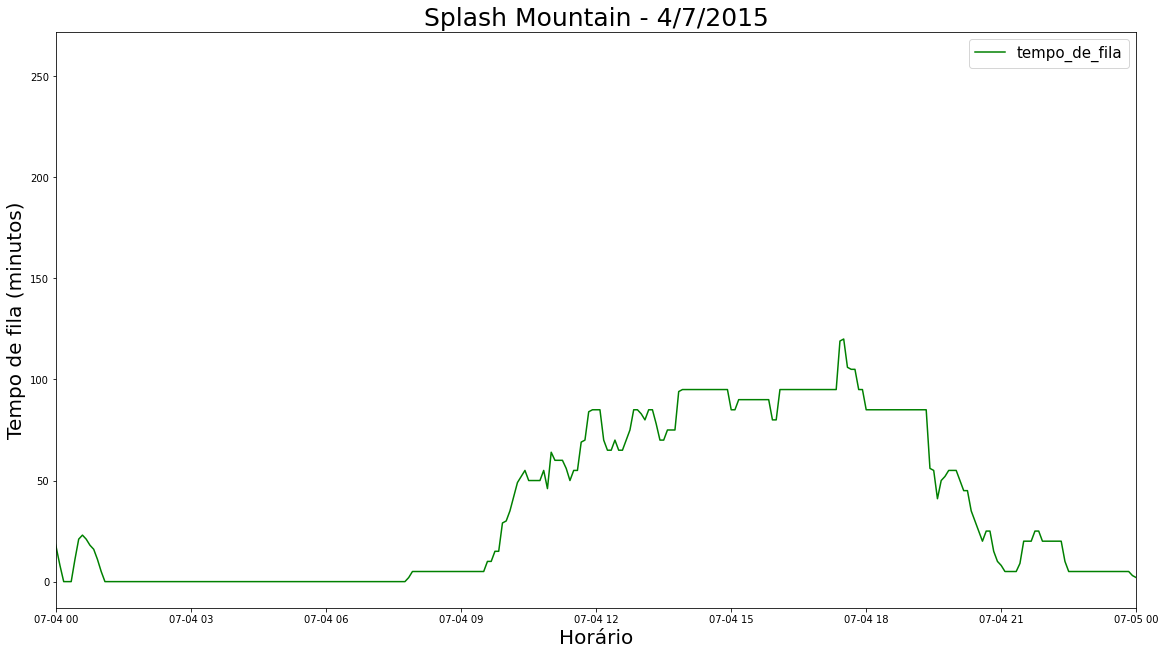

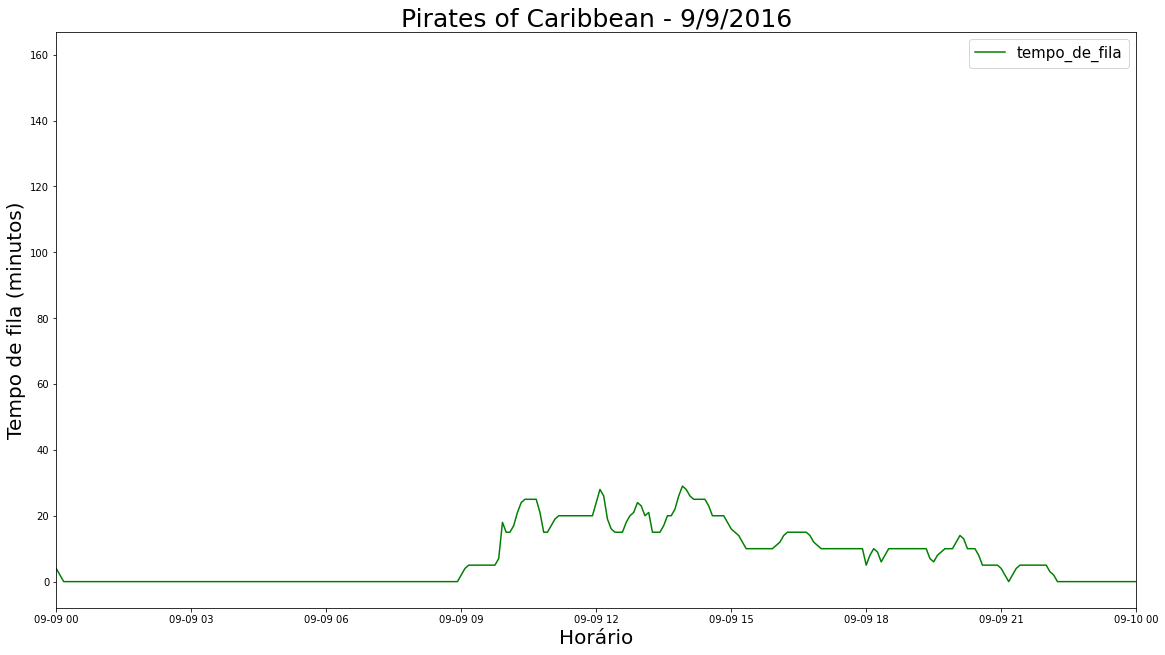

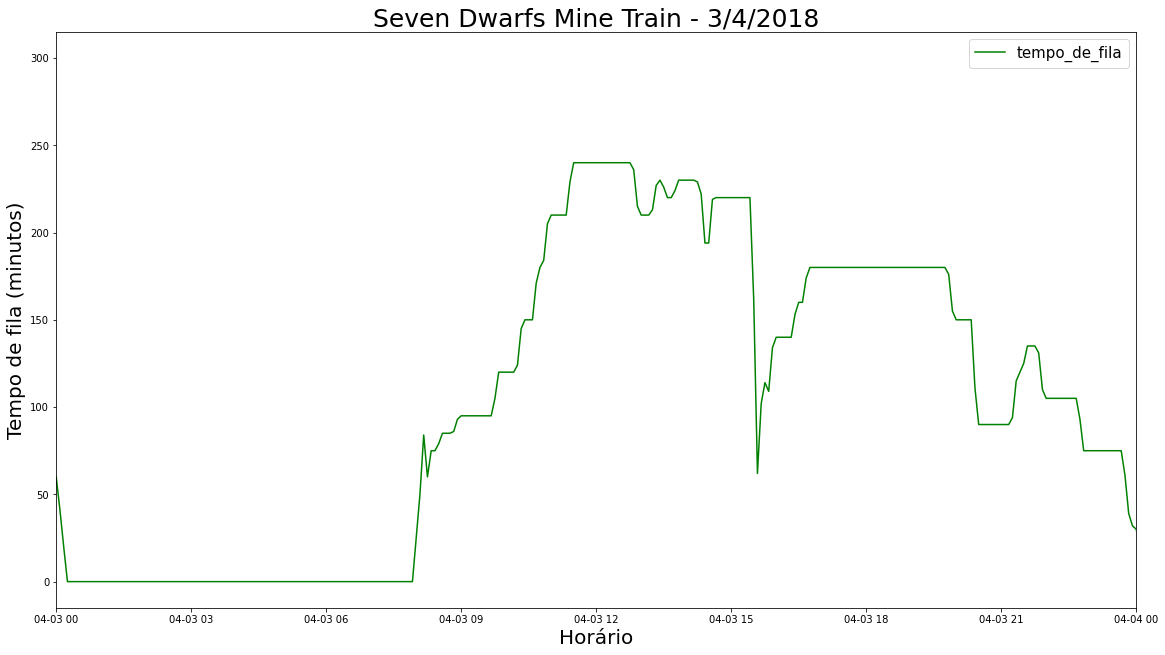

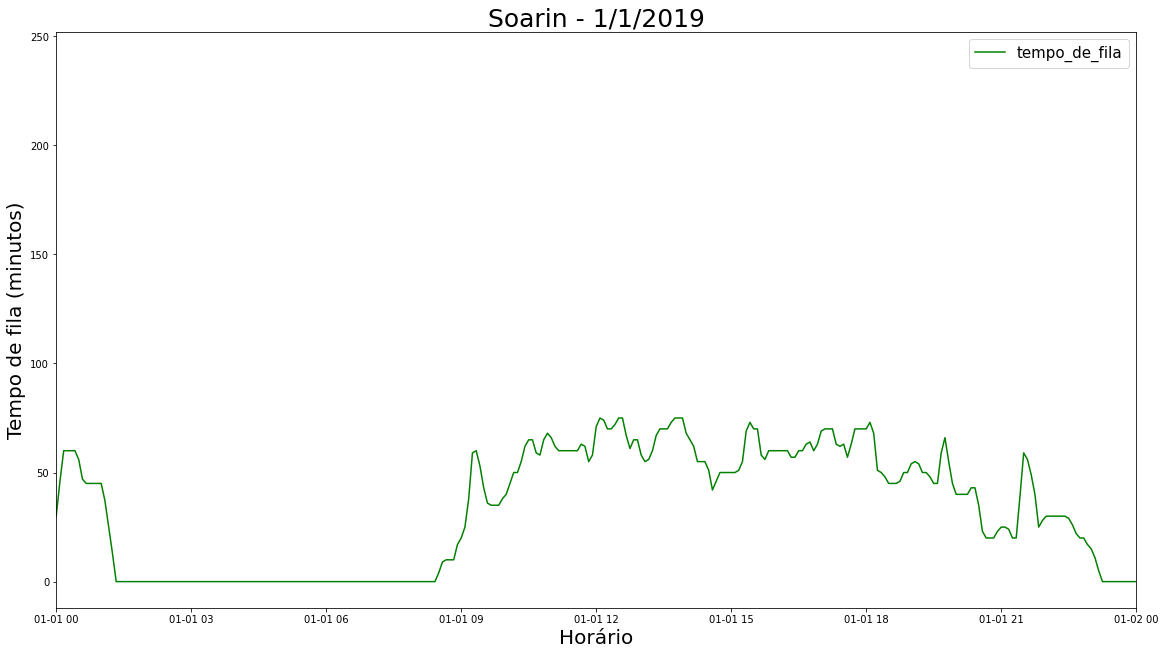

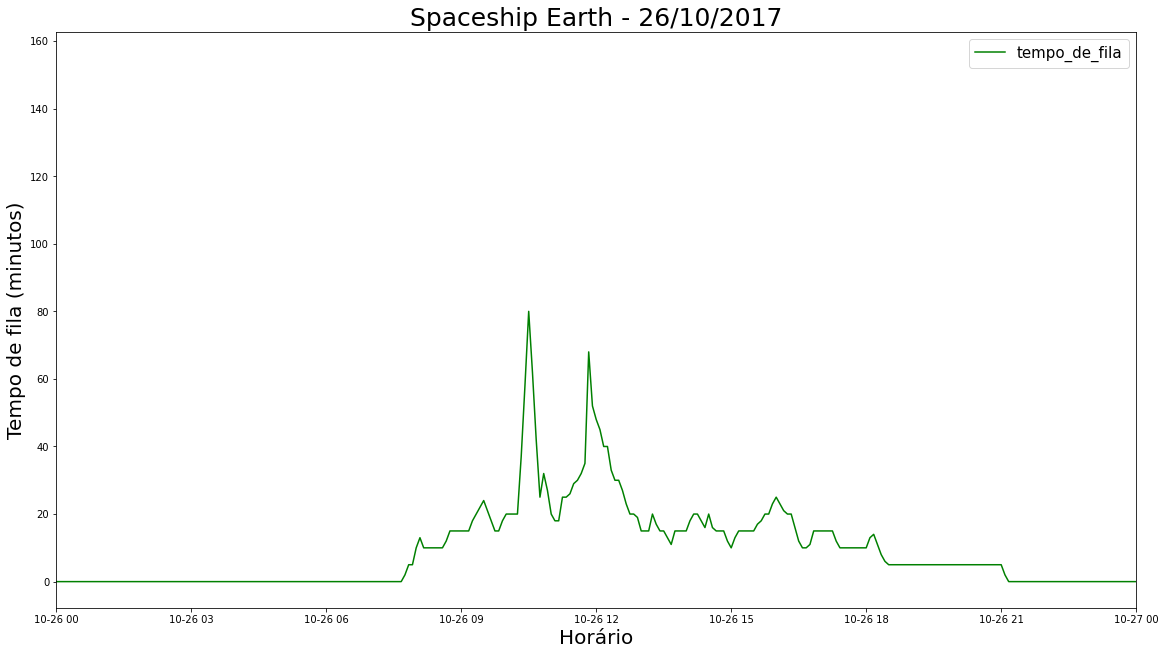

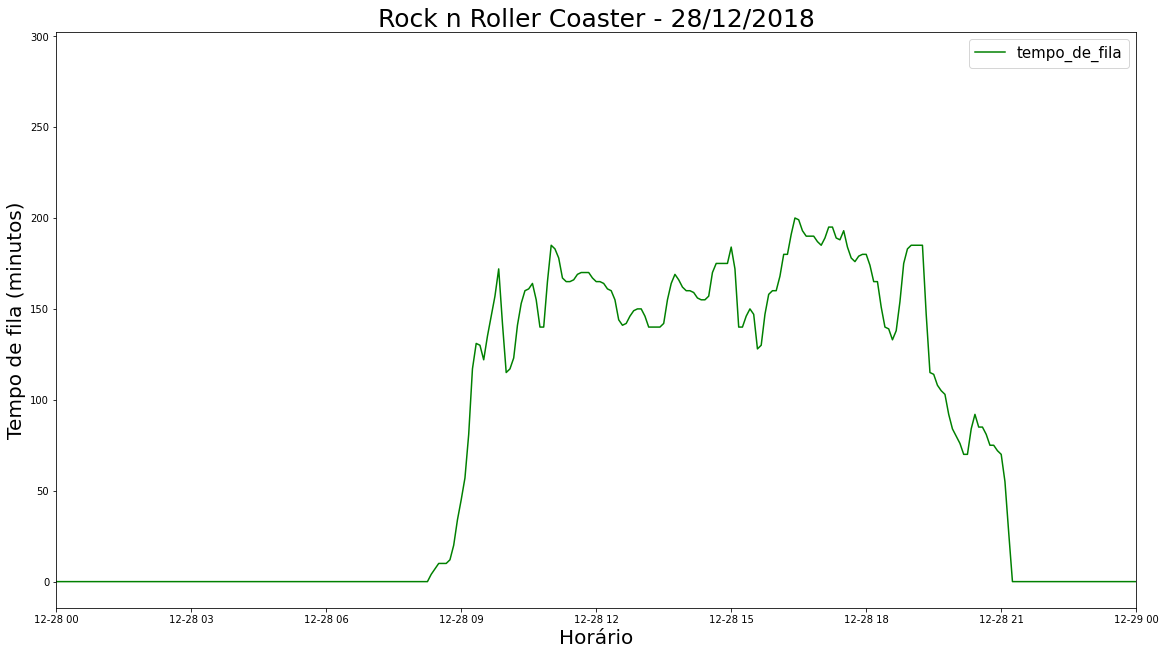

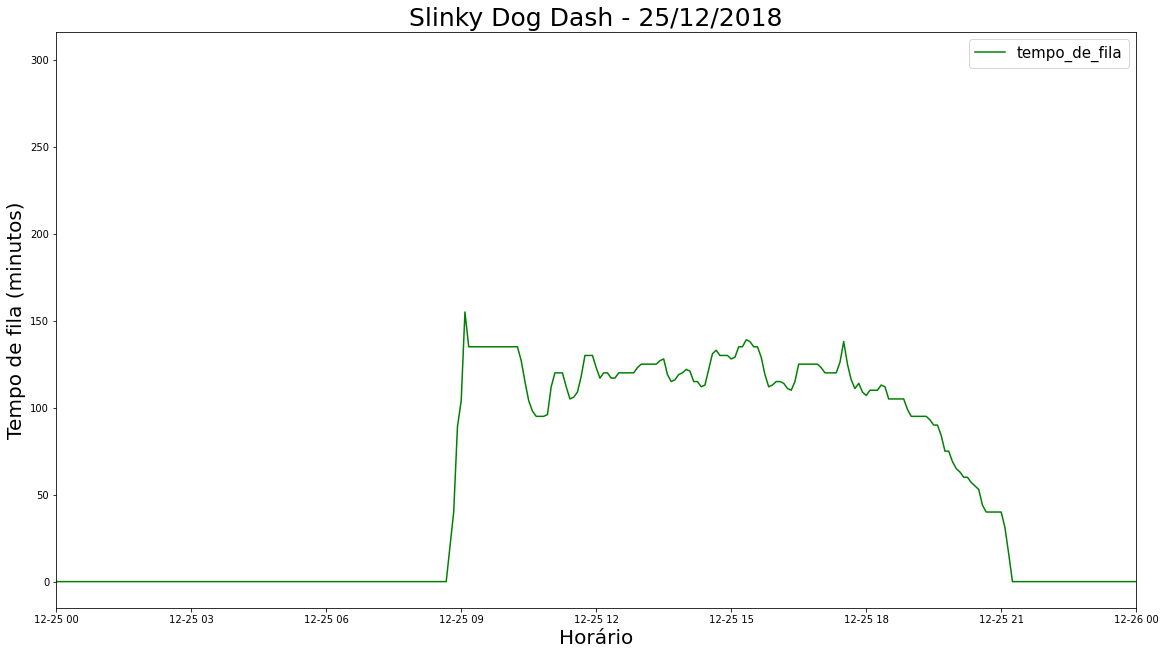

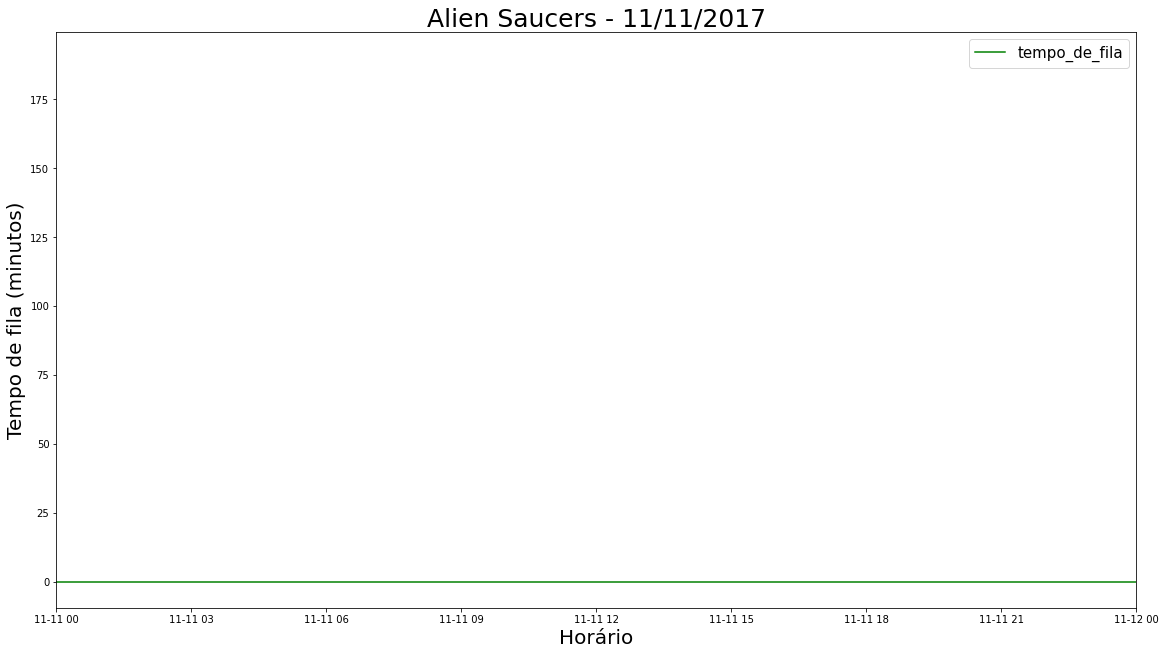

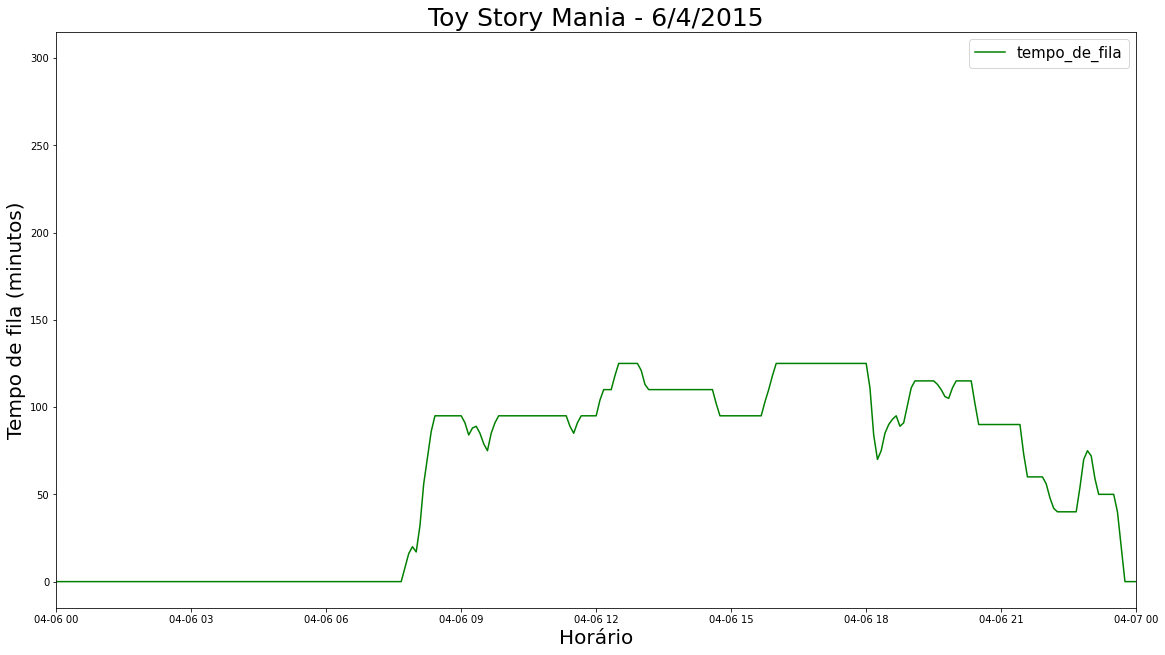

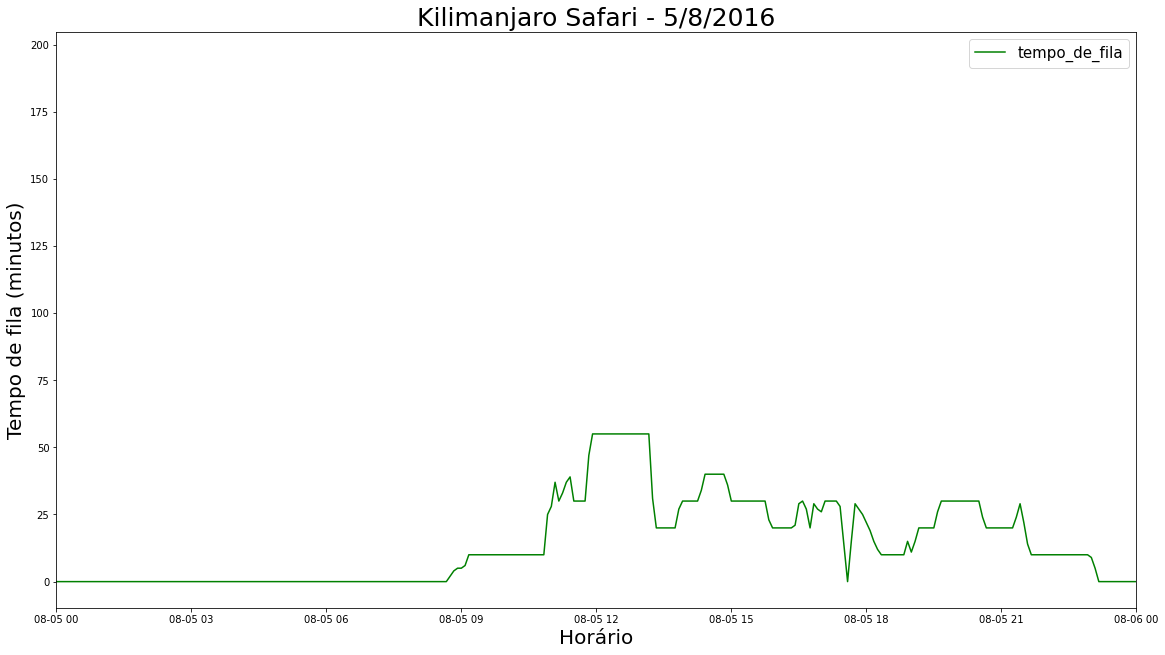

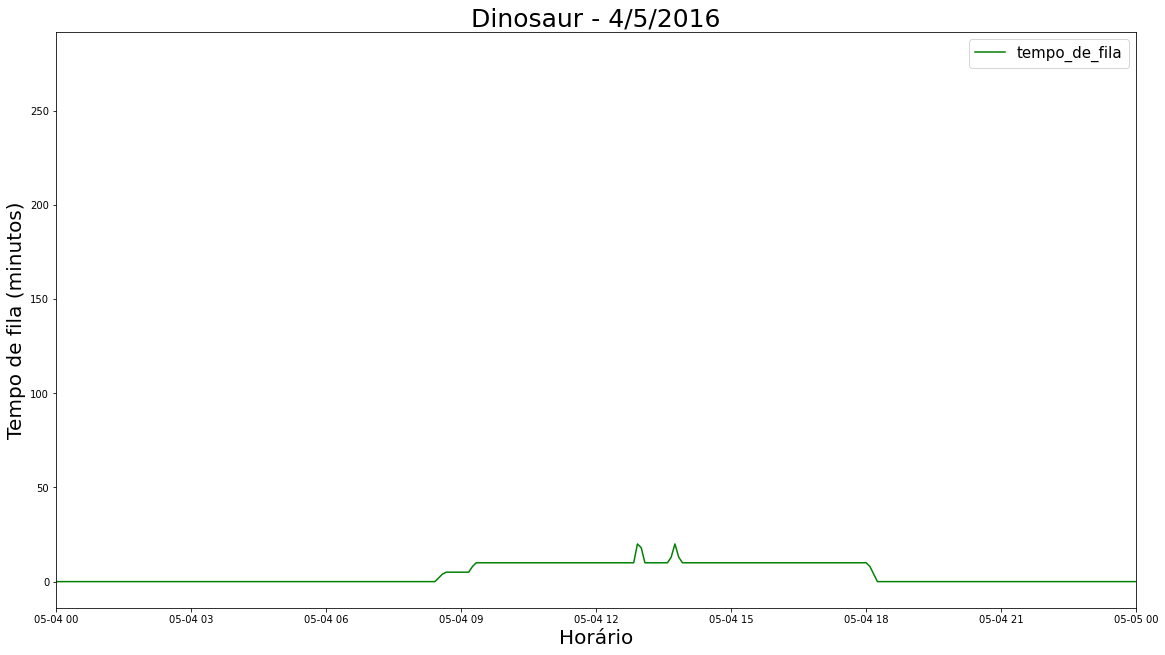

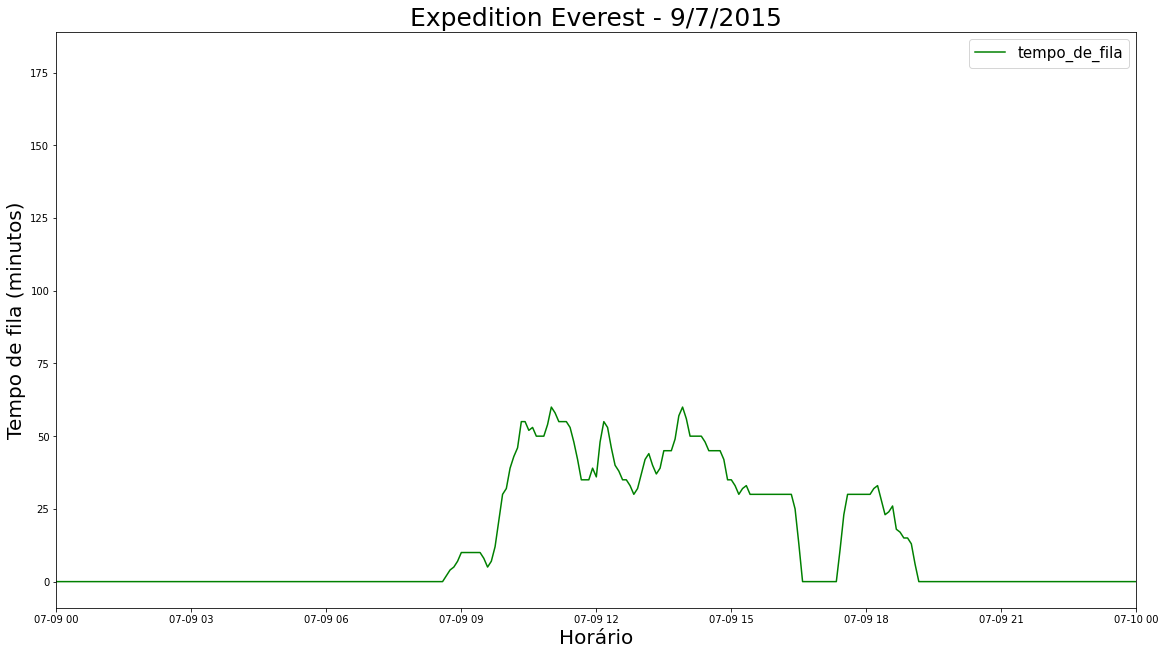

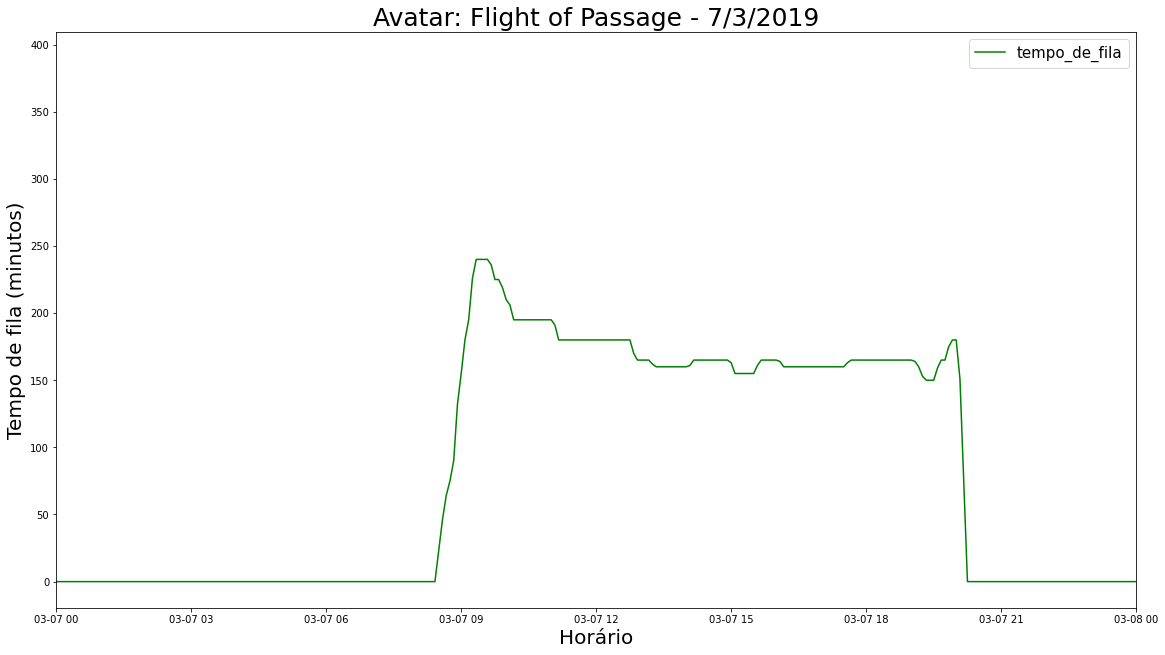

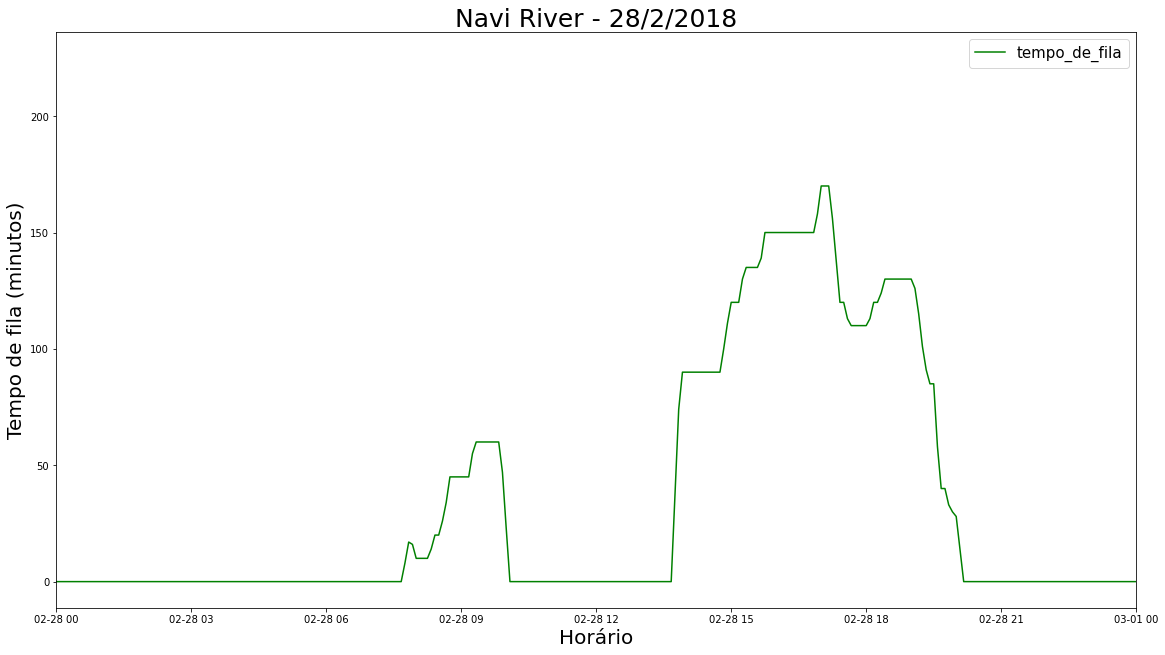

In [19]:
days = int(input('Quandos dias gostaria de analisar?'))
for days in range(0, days):
  ride = int(input('Escolha uma atração para analizar'))
  print('Você escolheu a atração {}'.format(nome_das_atracoes[ride]))
  print('Escolha uma data entre 01/01/2015 e 31/12/2019: ')
  d = int(input('Dia: '))
  m = int(input('Mês: '))
  y = int(input('Ano: '))
  data_escolhida = datetime(y, m, d)
  dia_seguinte = data_escolhida + timedelta(days=1)
  fig = plt.figure(figsize = (15,8))
  eixo = fig.add_axes([0, 0, 1, 1])
  eixo.plot(datasets_das_atracoes_3[ride]['data_e_hora'], datasets_das_atracoes_3[ride]['tempo_de_fila'], color = 'g')

  eixo.set_xlim(data_escolhida,dia_seguinte)
  eixo.set_title('{} - {}/{}/{}'.format(nome_das_atracoes[ride] , d, m, y), fontsize = 25)
  eixo.set_ylabel('Tempo de fila (minutos)', fontsize = 20)
  eixo.set_xlabel('Horário', fontsize = 20)
  eixo.legend(['tempo_de_fila'], loc = 'upper right', fontsize = 15)

## <font color=green>GRÁFICOS DA VARIAÇÃO DOS TEMPOS MÁXIMOS E MÉDIOS DIÁRIOS AO LONGO DOS ANOS</font>
***

### <font color=green>Criando os DataFrame com as datas, os tempos máximos e médios diários</font>
***

In [20]:
tempos_diarios_maximos = {}
tempos_diarios_medios = {}
tempos_diarios_8 = {}

for i in range(1,15):
  tempos_diarios_maximos[i] = datasets_das_atracoes_3[i].groupby(datasets_das_atracoes_3[i]['data_e_hora'].dt.date)['tempo_de_fila'].max()
  tempos_diarios_medios[i] = datasets_das_atracoes_3[i].groupby(datasets_das_atracoes_3[i]['data_e_hora'].dt.date)['tempo_de_fila'].mean()
  tempos_diarios_8[i] = datasets_das_atracoes_3[i].groupby(datasets_das_atracoes_3[i]['data_e_hora'].dt.date)['tempo_de_fila'].quantile(0.8)

In [21]:
datas = pd.date_range(start='1/1/2015', periods = 1826, freq = 'd')
index_days = range(0,1826)

In [22]:
tempos_diarios_maximos_df = {}
tempos_diarios_medios_df = {}
tempos_diarios_8_df = {}

for i in range(1,15):
  tempos_diarios_maximos_df[i] = pd.DataFrame(index = index_days, columns = ['data', 'tempo_maximo'])
  tempos_diarios_maximos_df[i]['data'] = datas
  for j in index_days:
    tempos_diarios_maximos_df[i].tempo_maximo[j] = tempos_diarios_maximos[i][j]

for i in range(1,15):
  tempos_diarios_medios_df[i] = pd.DataFrame(index = index_days, columns = ['data', 'tempo_medio'])
  tempos_diarios_medios_df[i]['data'] = datas
  for j in index_days:
    tempos_diarios_medios_df[i].tempo_medio[j] = np.around(tempos_diarios_medios[i][j], decimals = 0)

for i in range(1,15):
  tempos_diarios_8_df[i] = pd.DataFrame(index = index_days, columns = ['data', 'tempo_percentil_80'])
  tempos_diarios_8_df[i]['data'] = datas
  for j in index_days:
    tempos_diarios_8_df[i].tempo_percentil_80[j] = np.around(tempos_diarios_8[i][j], decimals = 0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### <font color=green>Plotando gráficos com a variação anual dos tempos máximos e médios de fila</font>
***

Quantas gráficos anuais você quer visualizar?20
Escolha uma atração: 1
Escolha um ano de 2015 a 2019: 2015
Escolha uma atração: 1
Escolha um ano de 2015 a 2019: 2016
Escolha uma atração: 1
Escolha um ano de 2015 a 2019: 2017
Escolha uma atração: 1
Escolha um ano de 2015 a 2019: 2018
Escolha uma atração: 1
Escolha um ano de 2015 a 2019: 2019
Escolha uma atração: 5
Escolha um ano de 2015 a 2019: 2015
Escolha uma atração: 5
Escolha um ano de 2015 a 2019: 2016
Escolha uma atração: 5
Escolha um ano de 2015 a 2019: 2017
Escolha uma atração: 5
Escolha um ano de 2015 a 2019: 2018
Escolha uma atração: 5
Escolha um ano de 2015 a 2019: 2019
Escolha uma atração: 7
Escolha um ano de 2015 a 2019: 2015
Escolha uma atração: 7
Escolha um ano de 2015 a 2019: 2016
Escolha uma atração: 7
Escolha um ano de 2015 a 2019: 2017
Escolha uma atração: 7
Escolha um ano de 2015 a 2019: 2018
Escolha uma atração: 7
Escolha um ano de 2015 a 2019: 2019
Escolha uma atração: 12
Escolha um ano de 2015 a 2019: 2015
Escolha

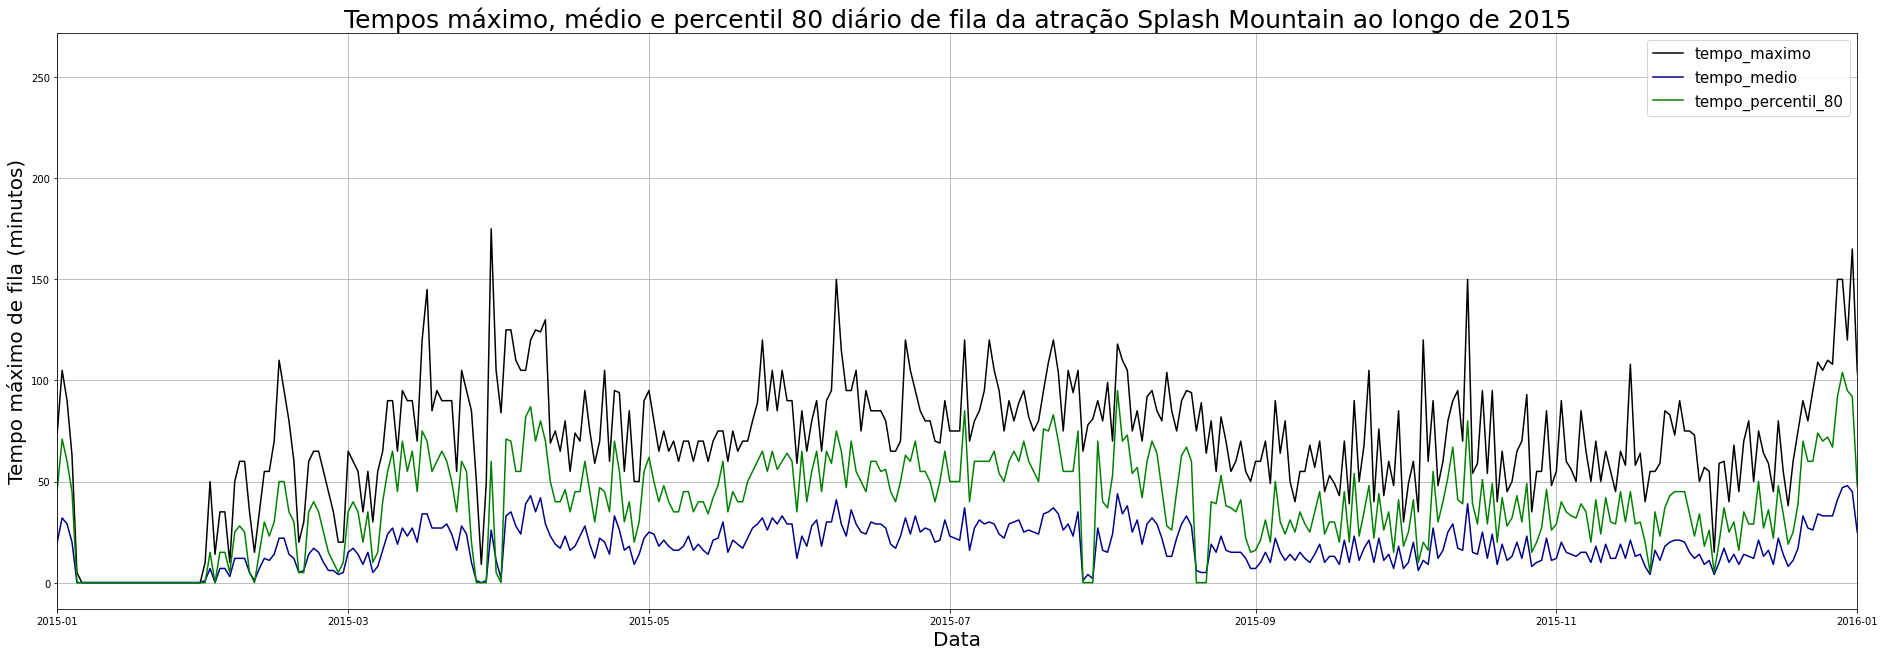

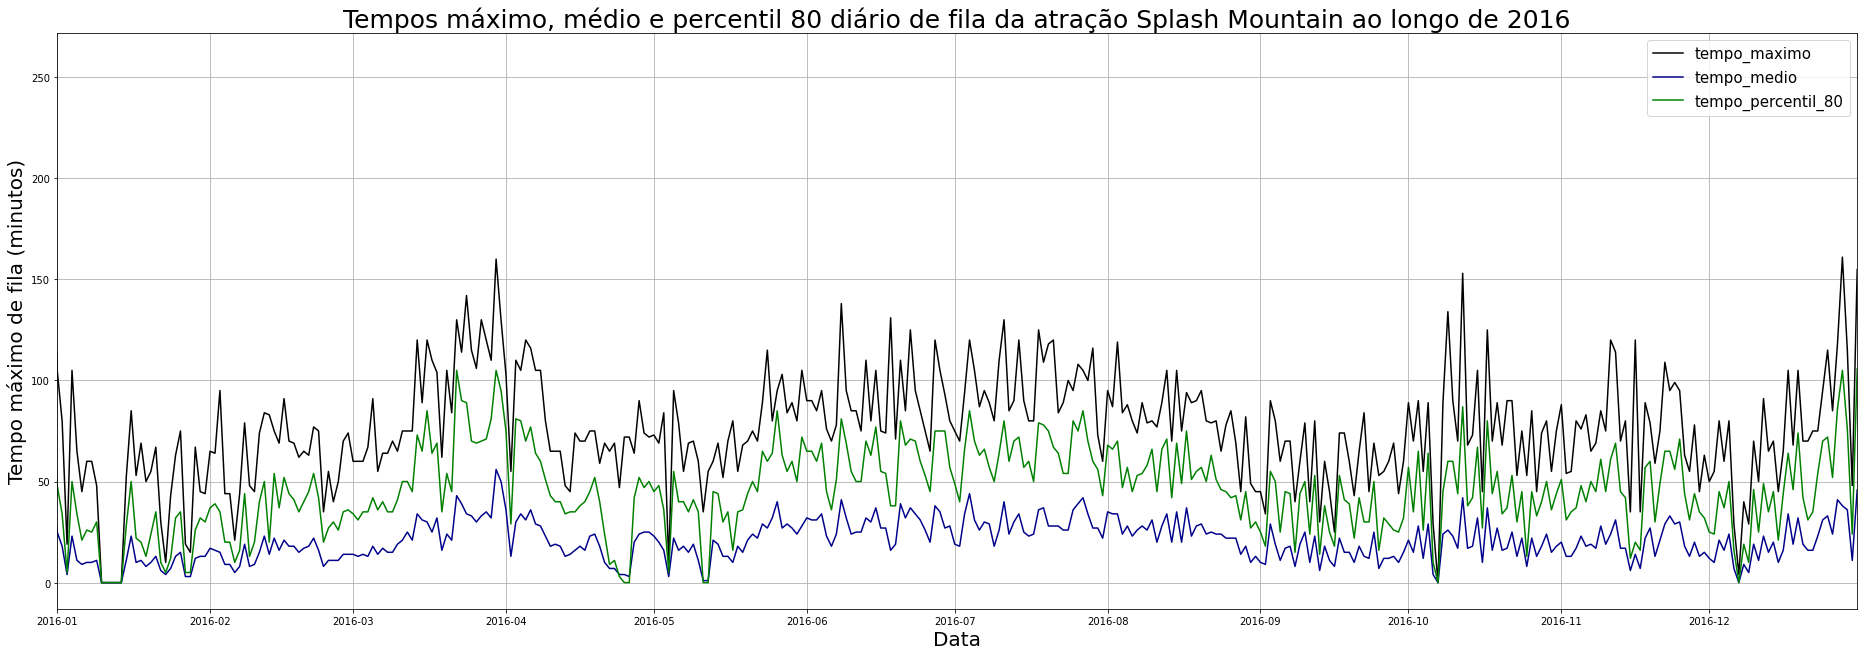

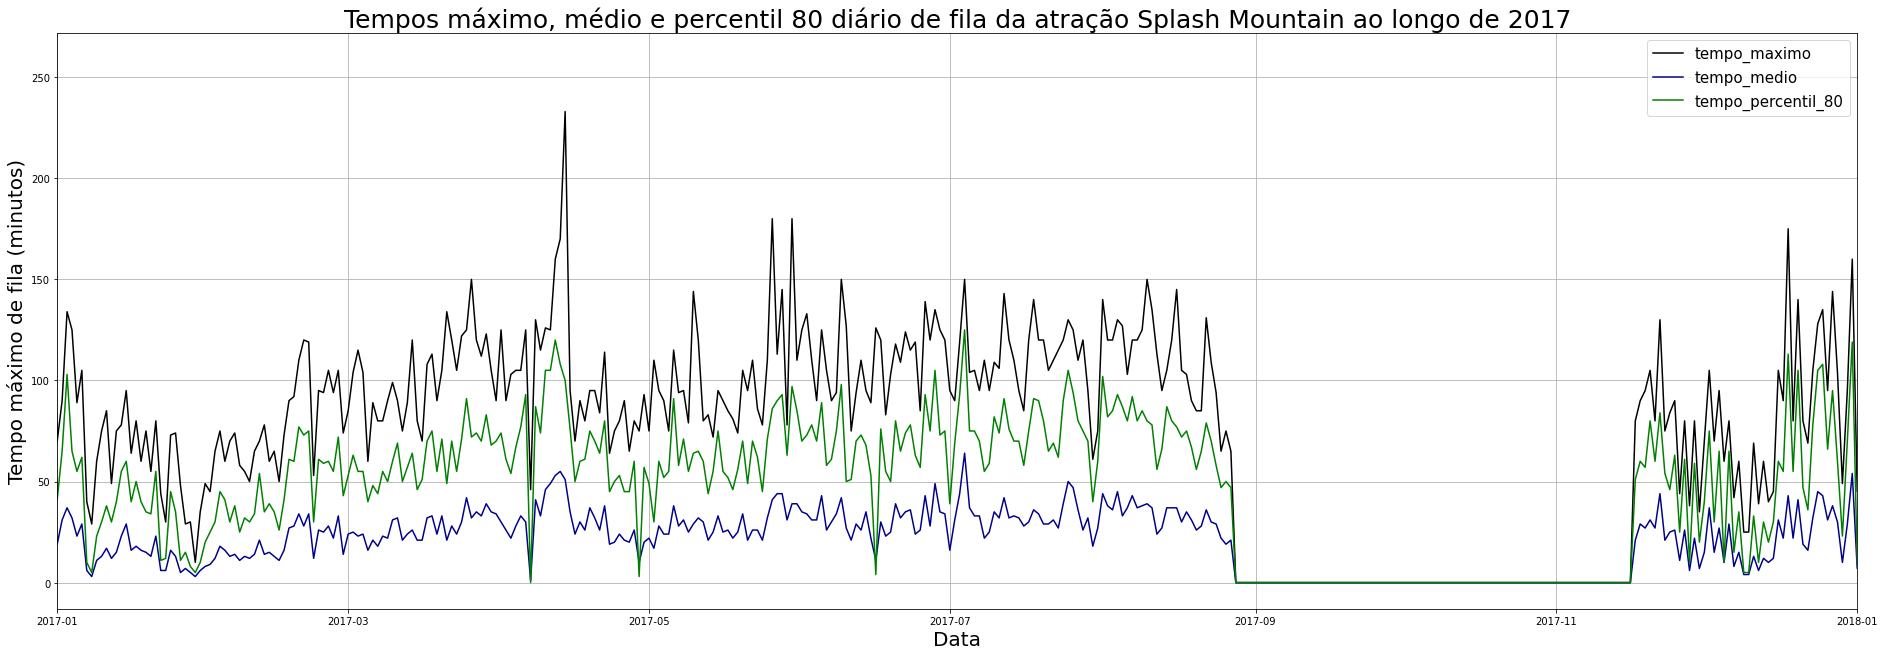

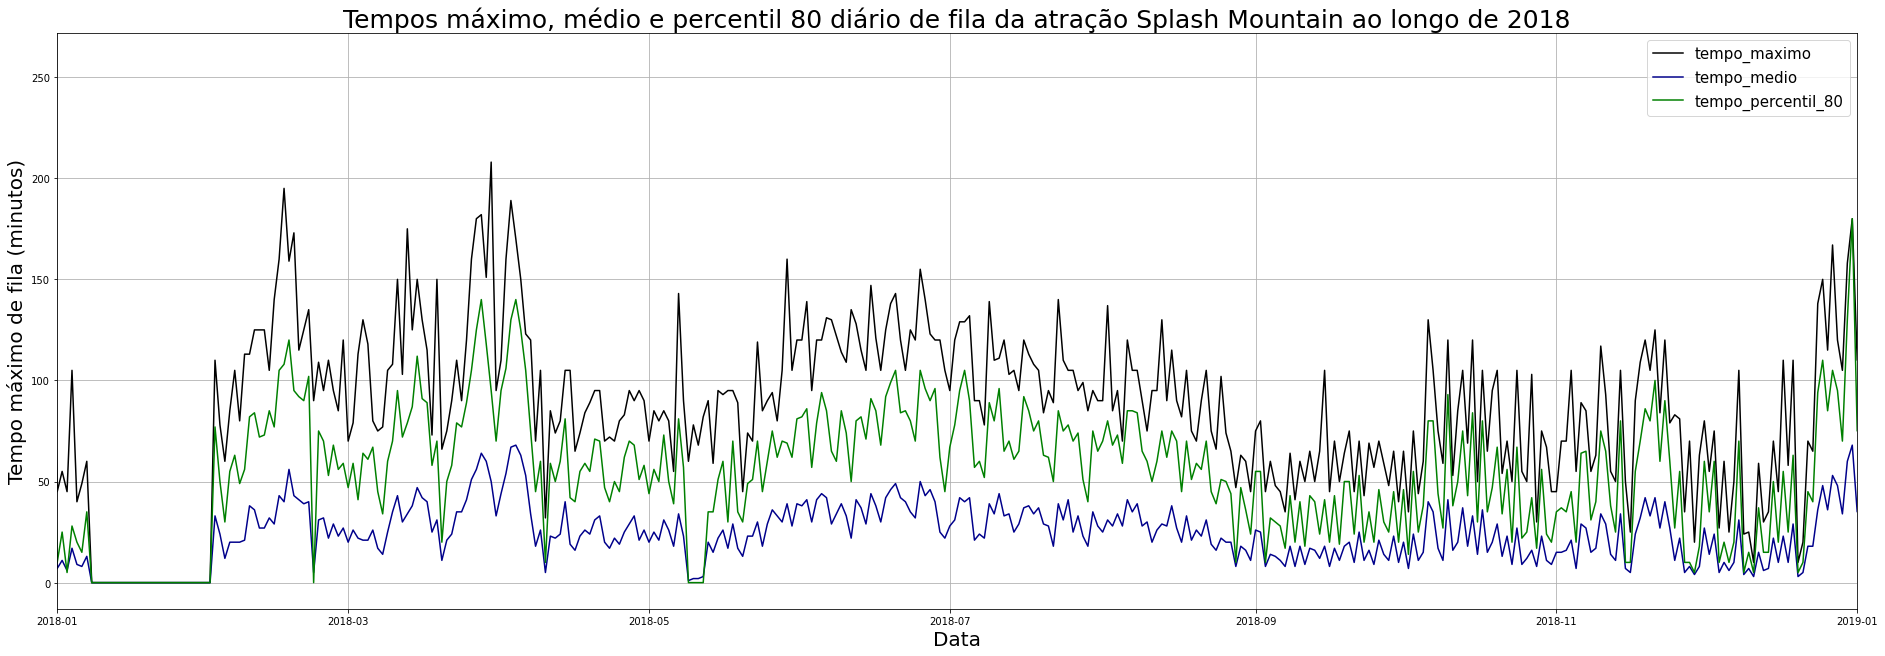

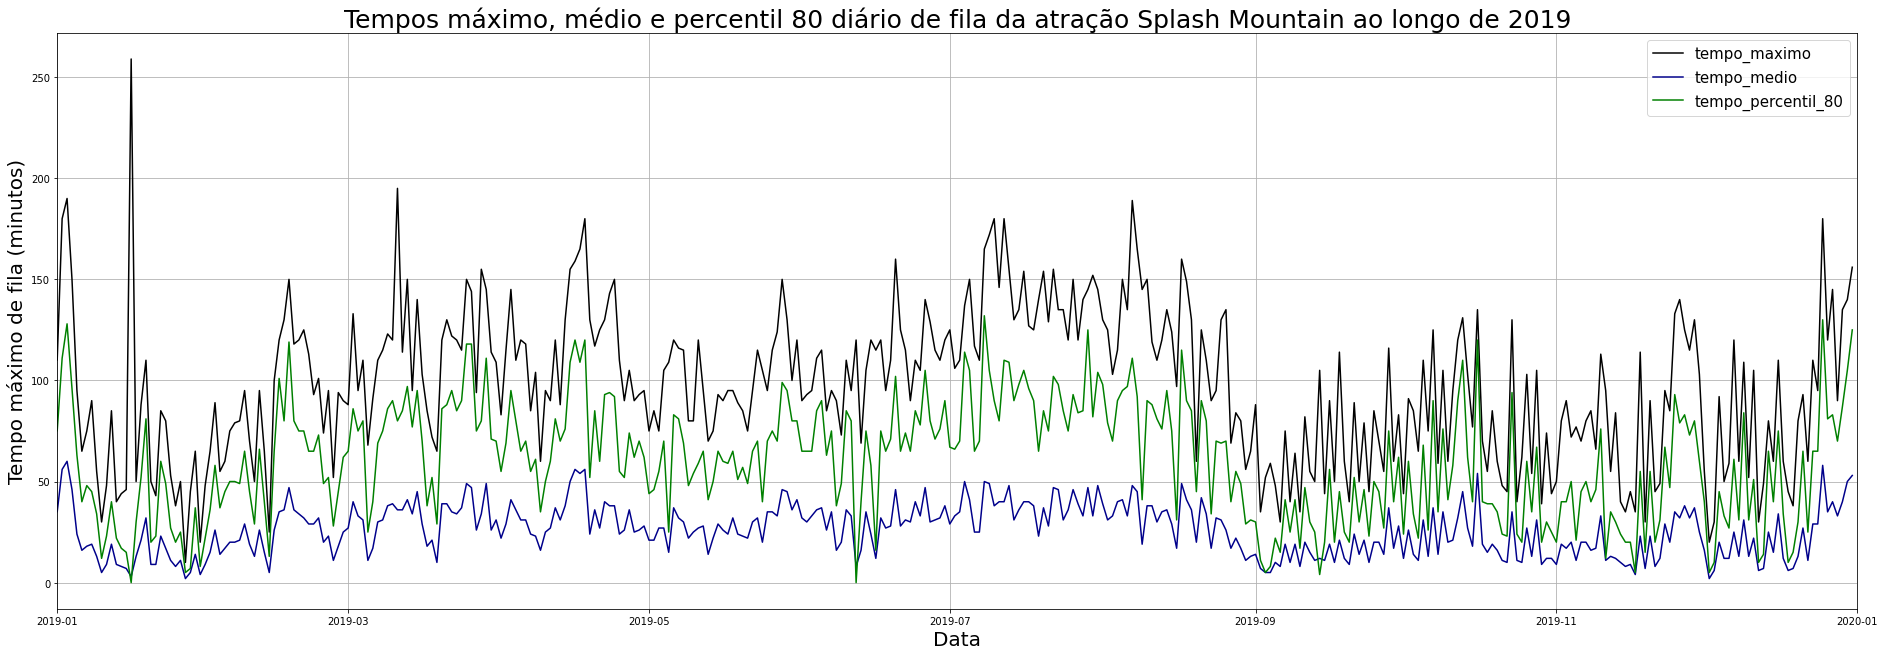

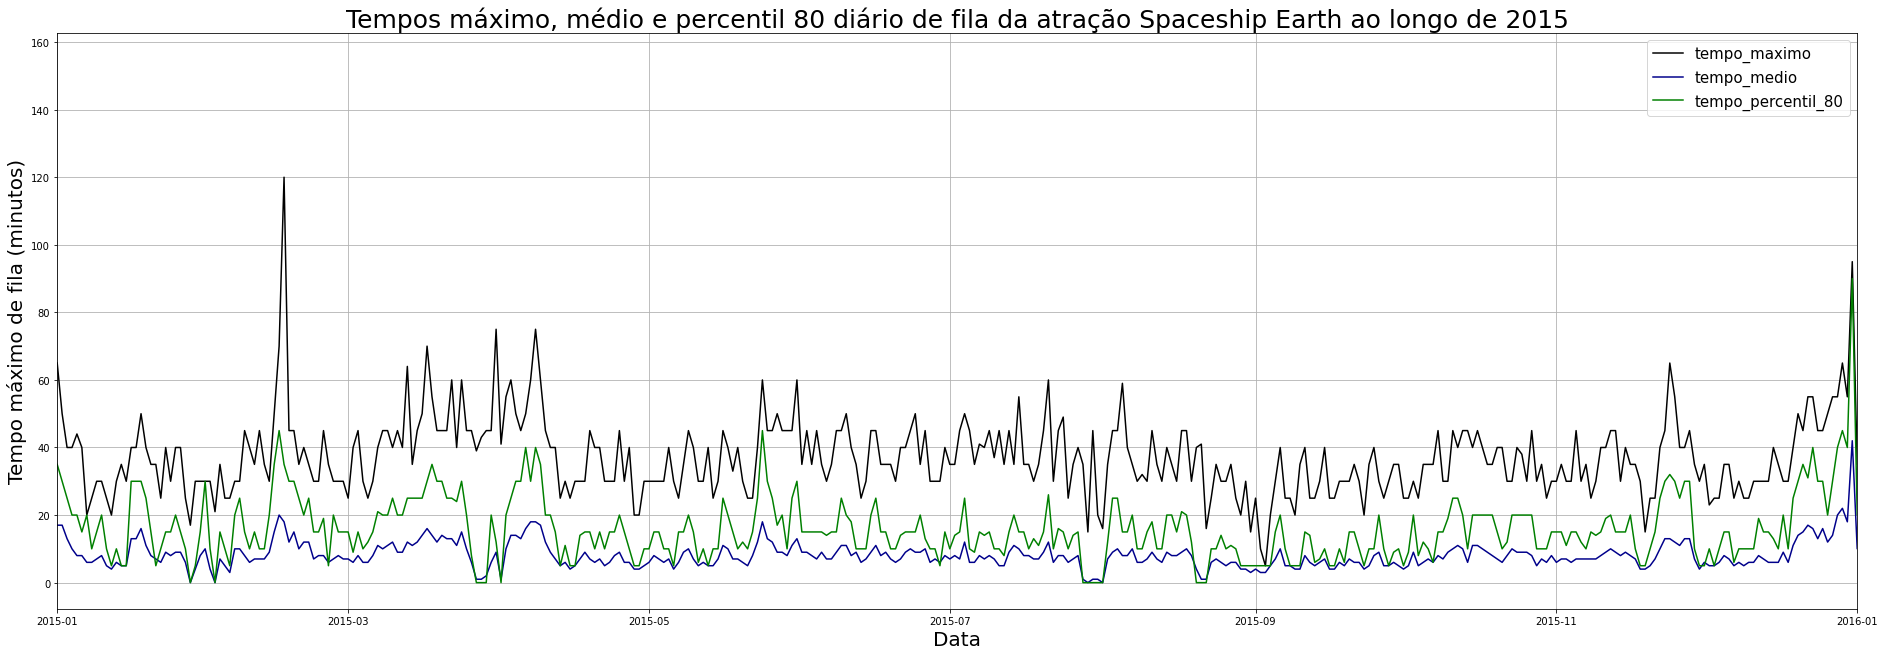

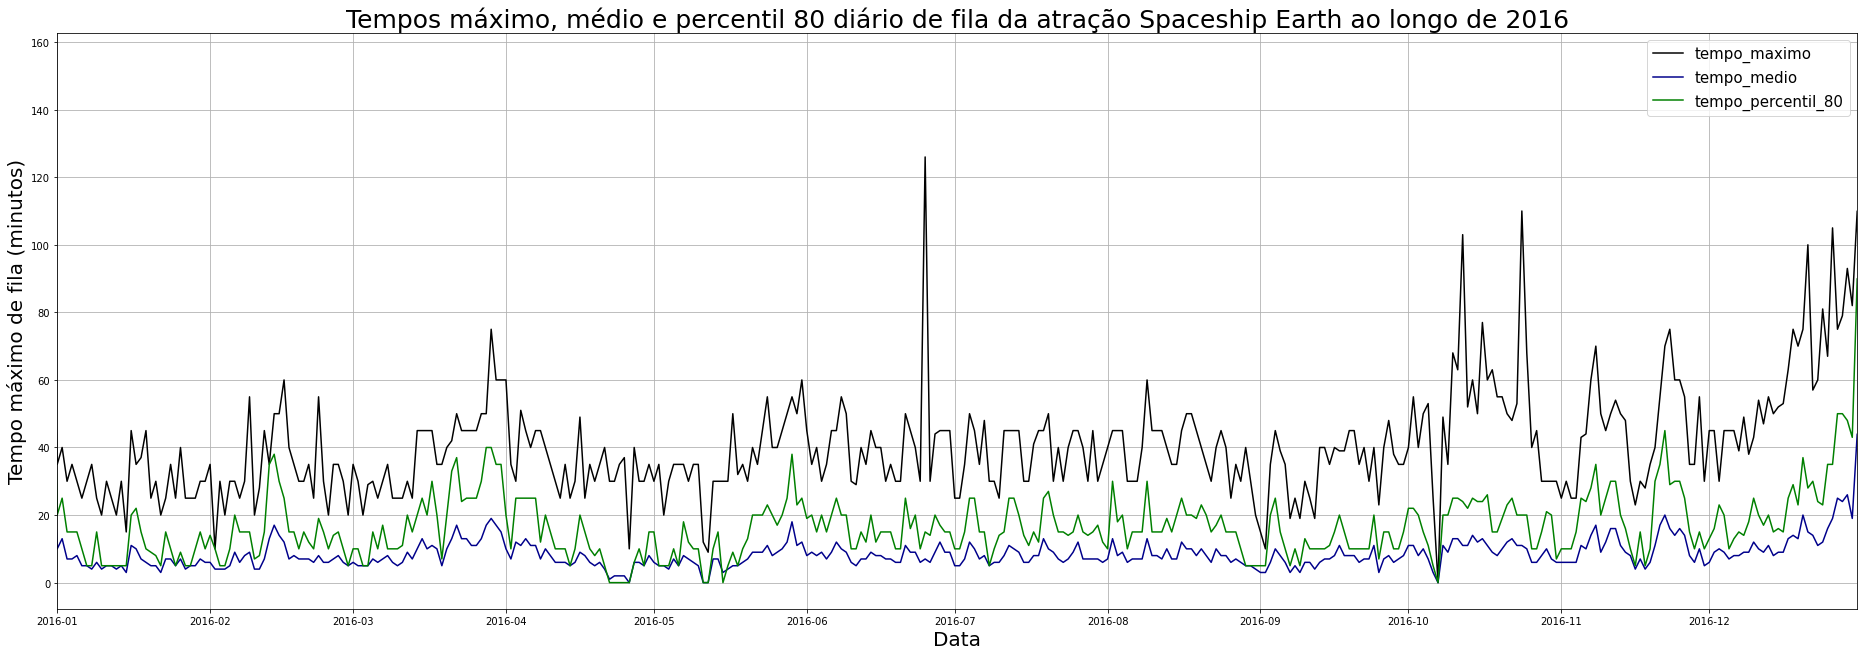

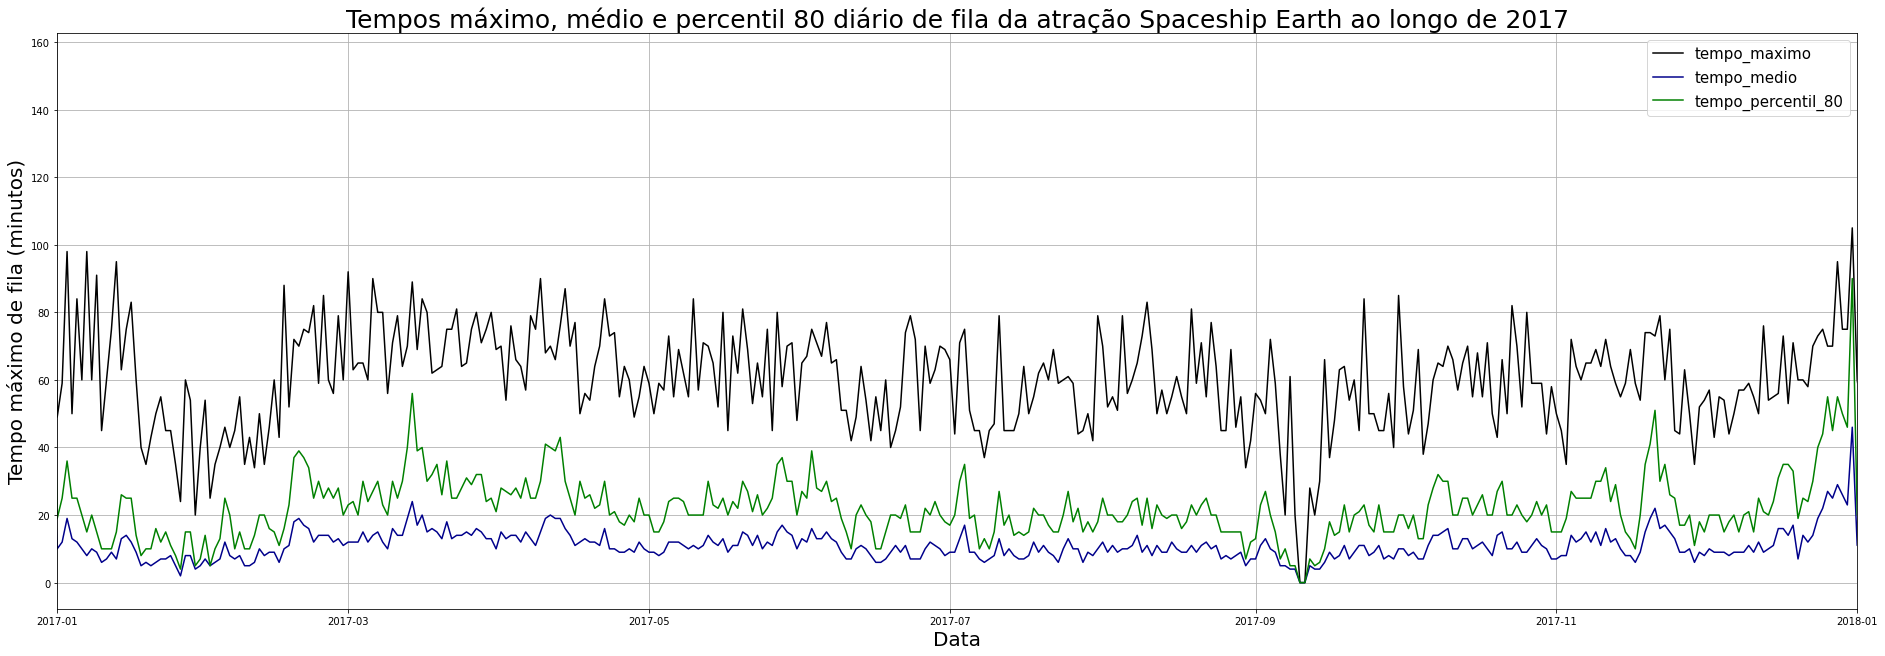

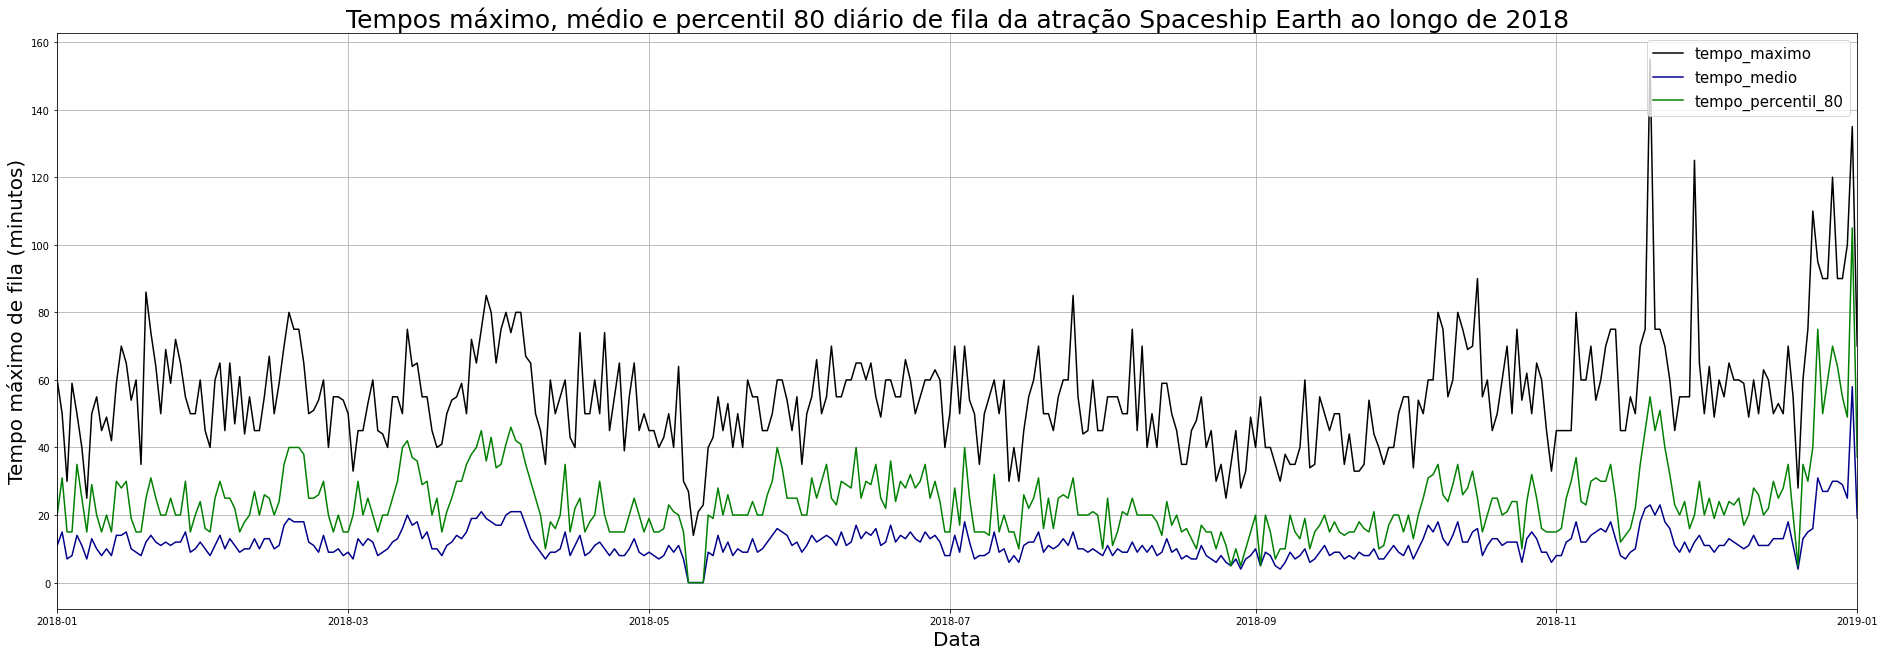

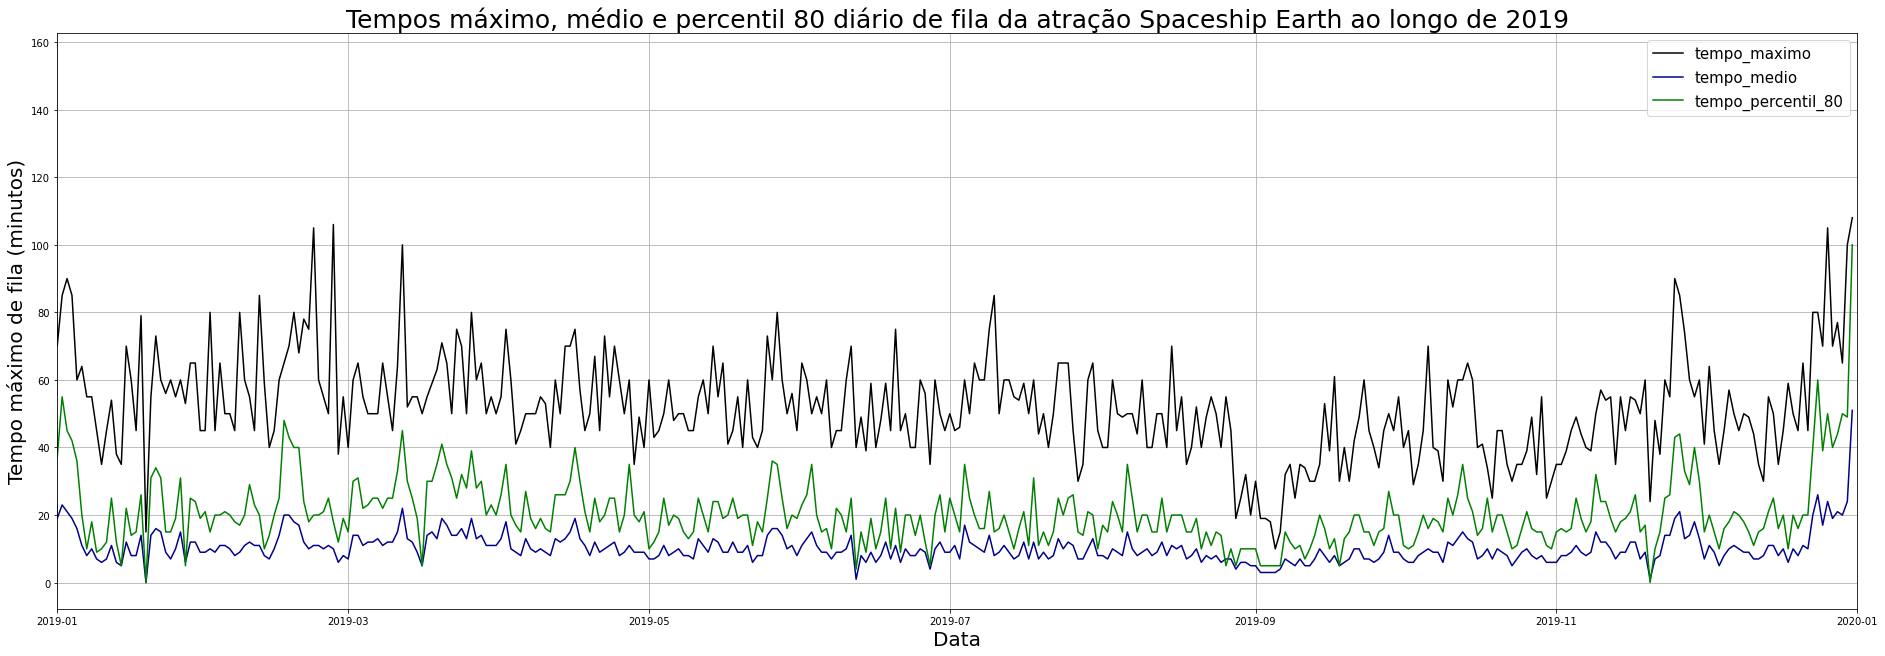

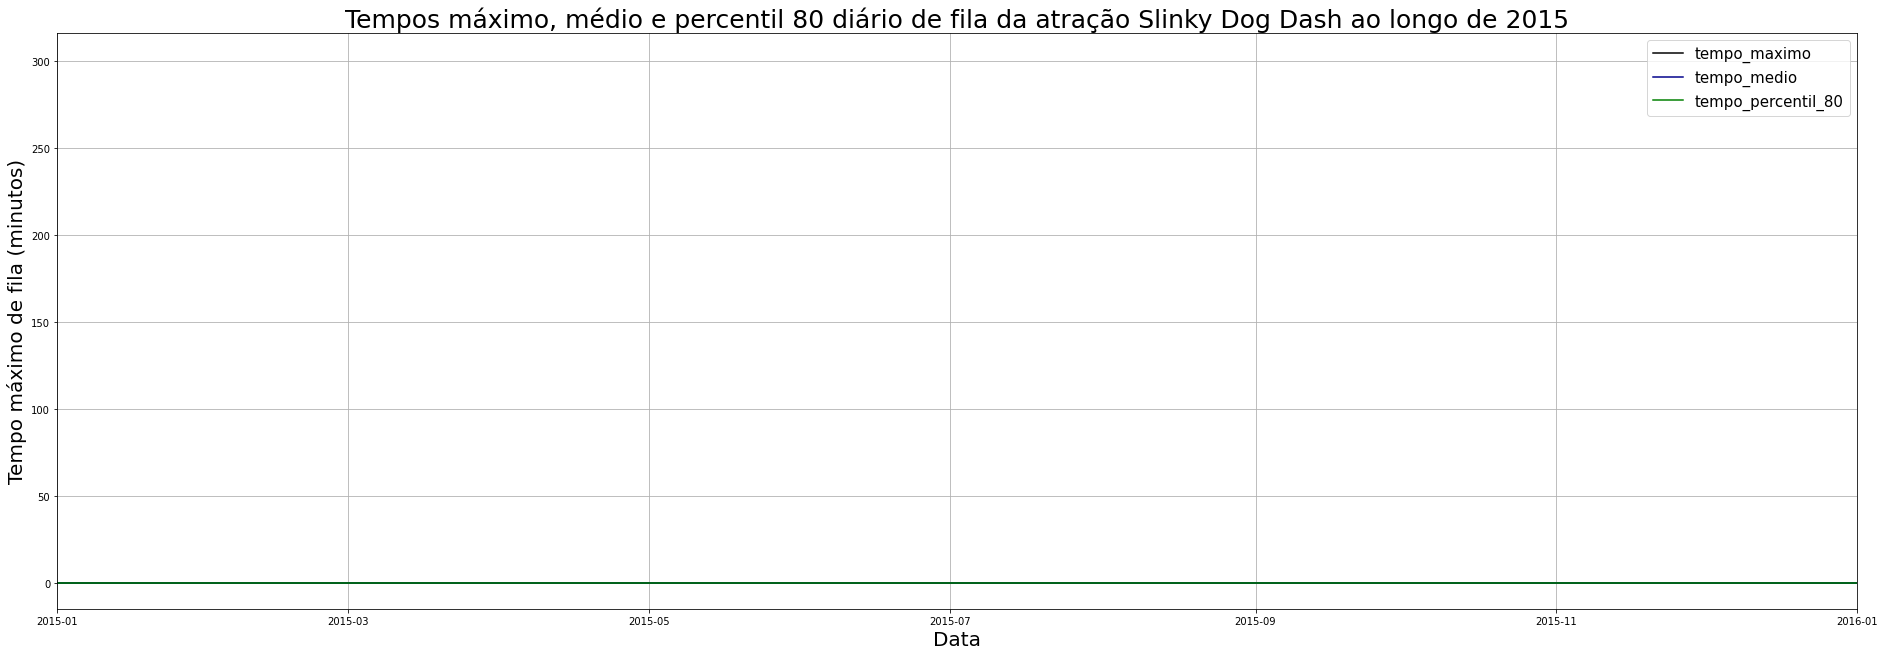

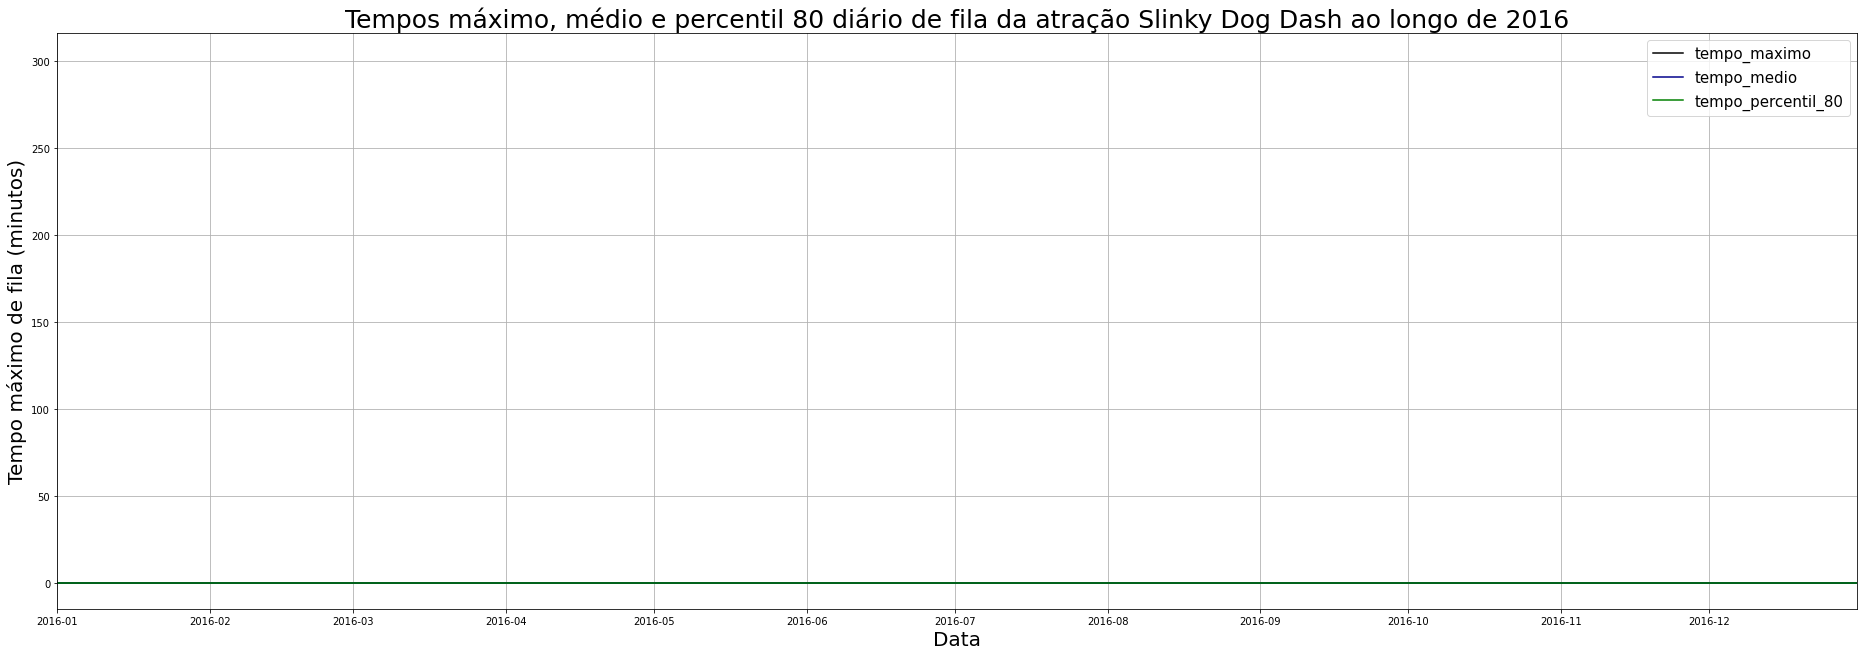

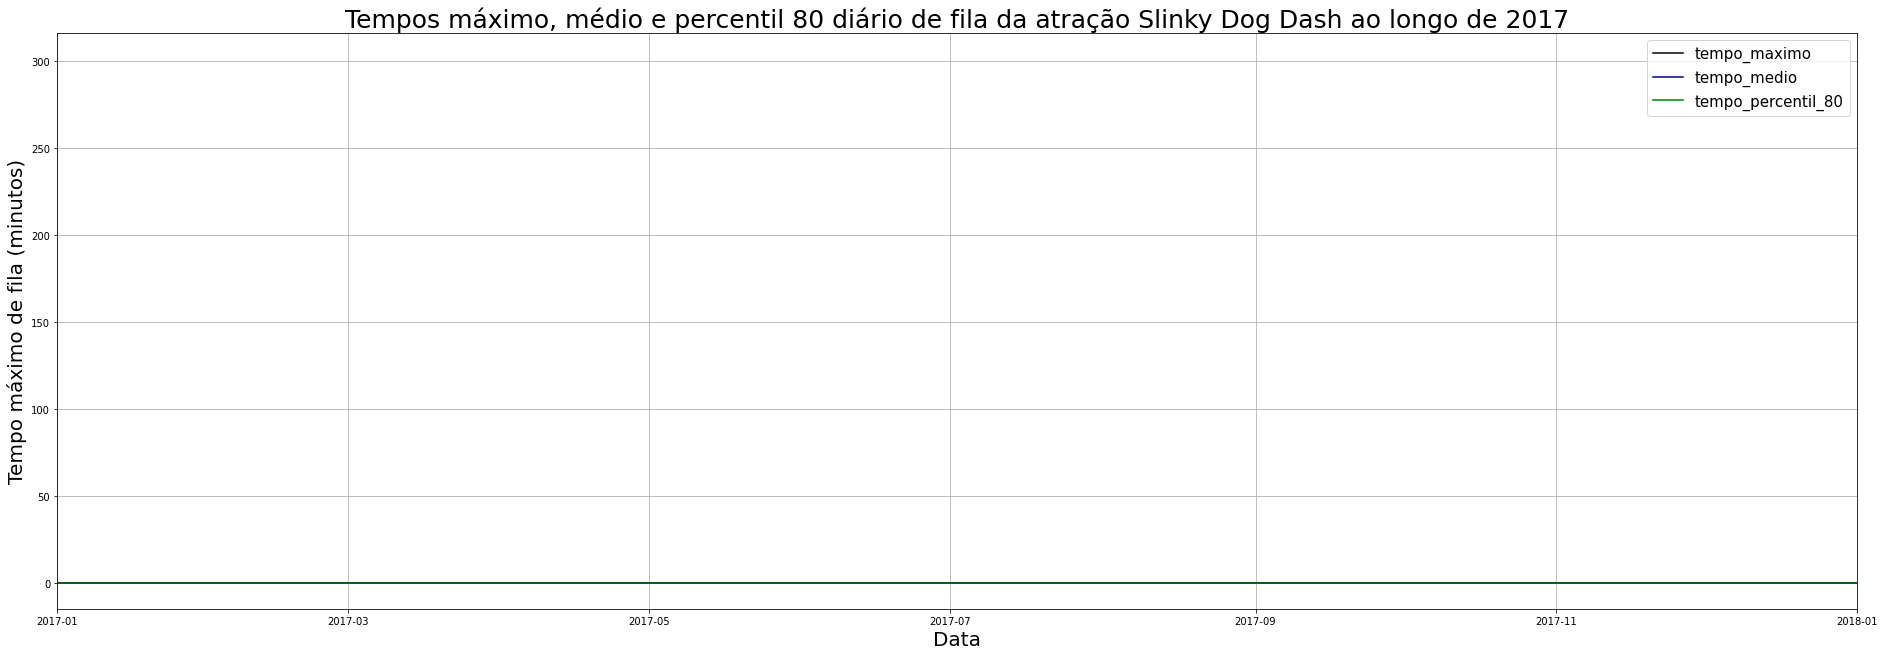

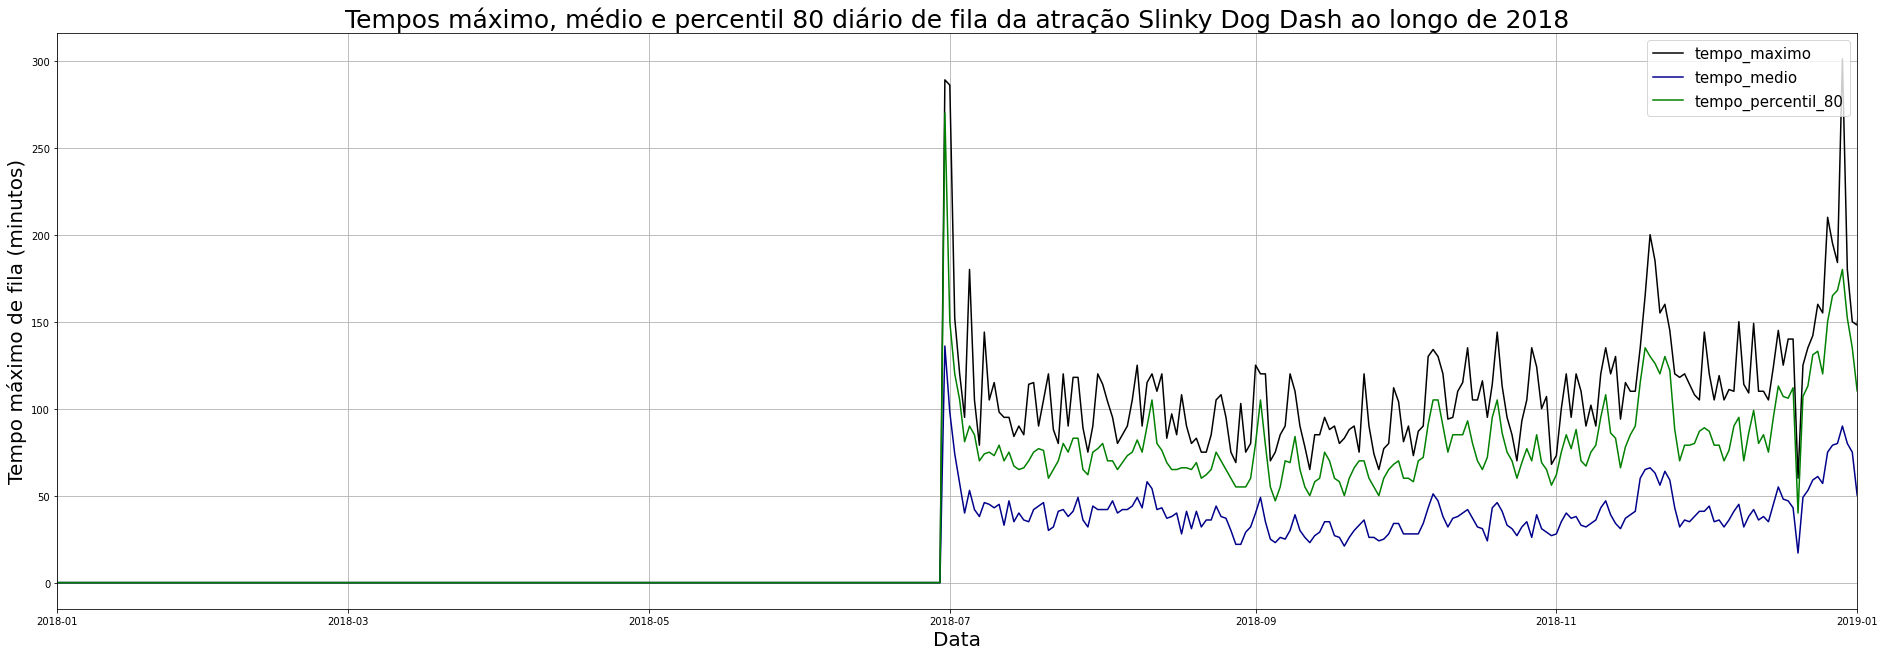

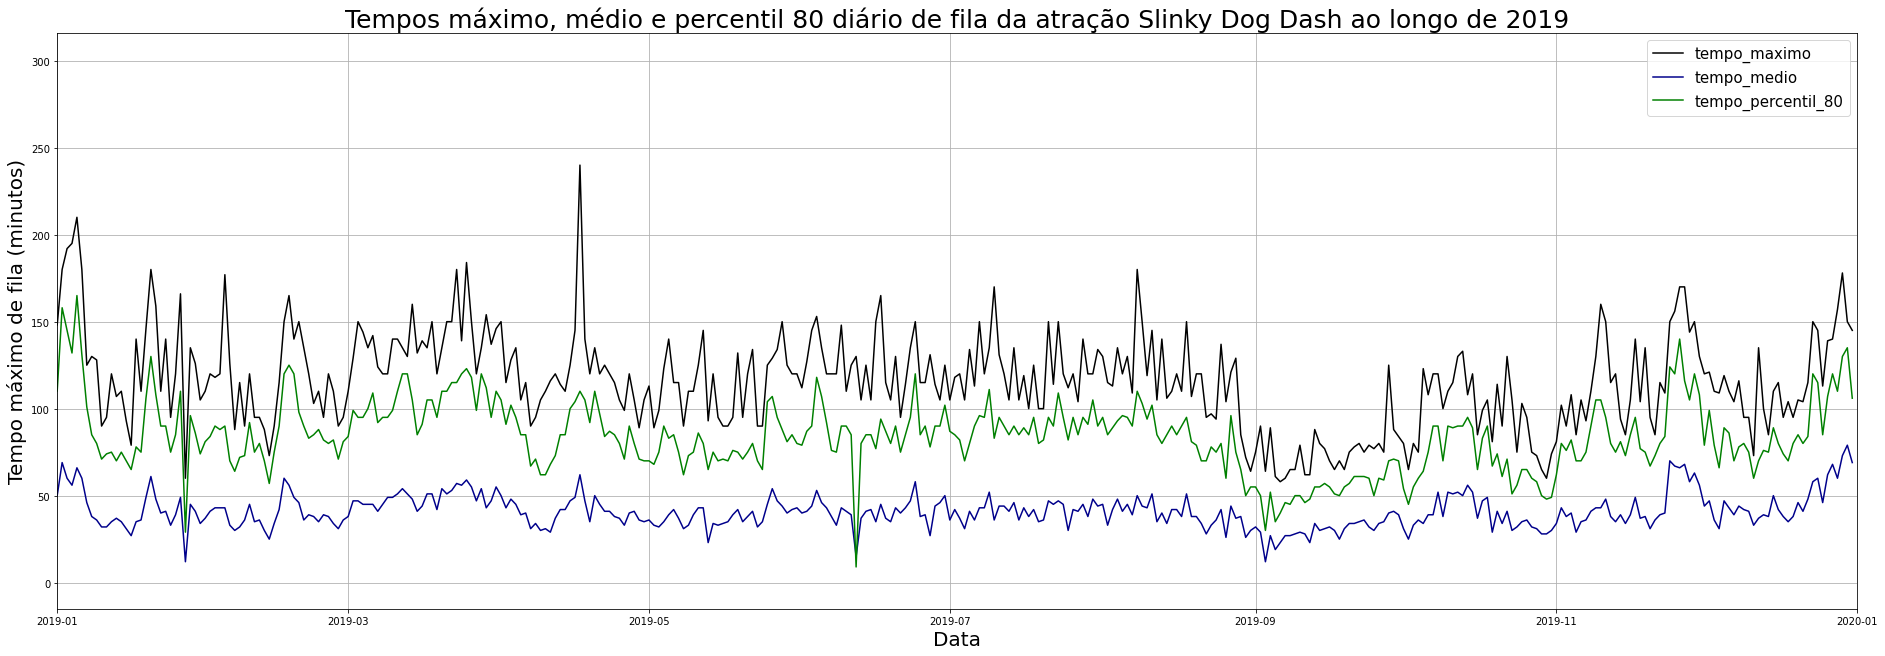

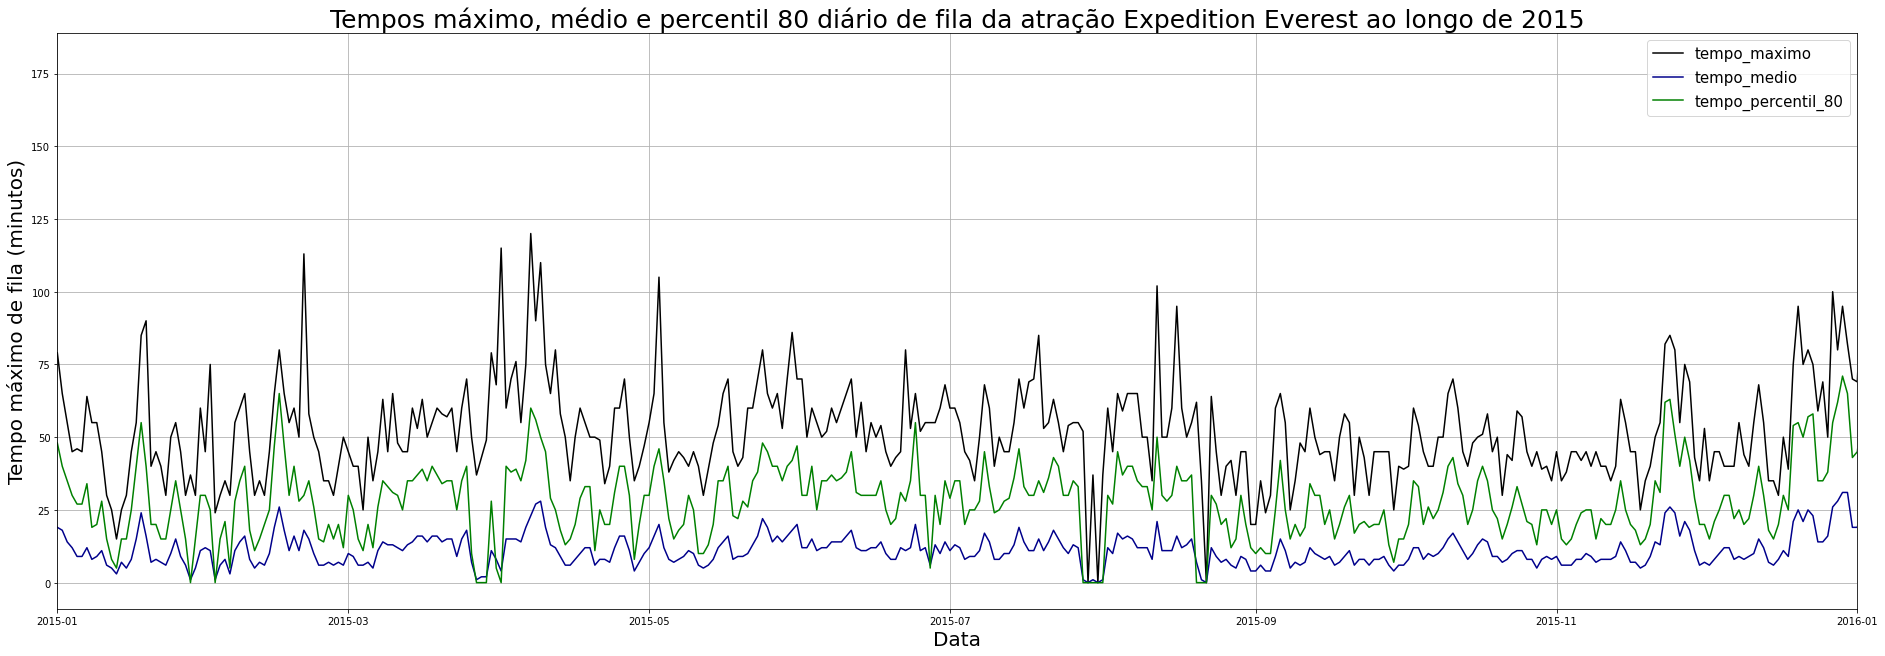

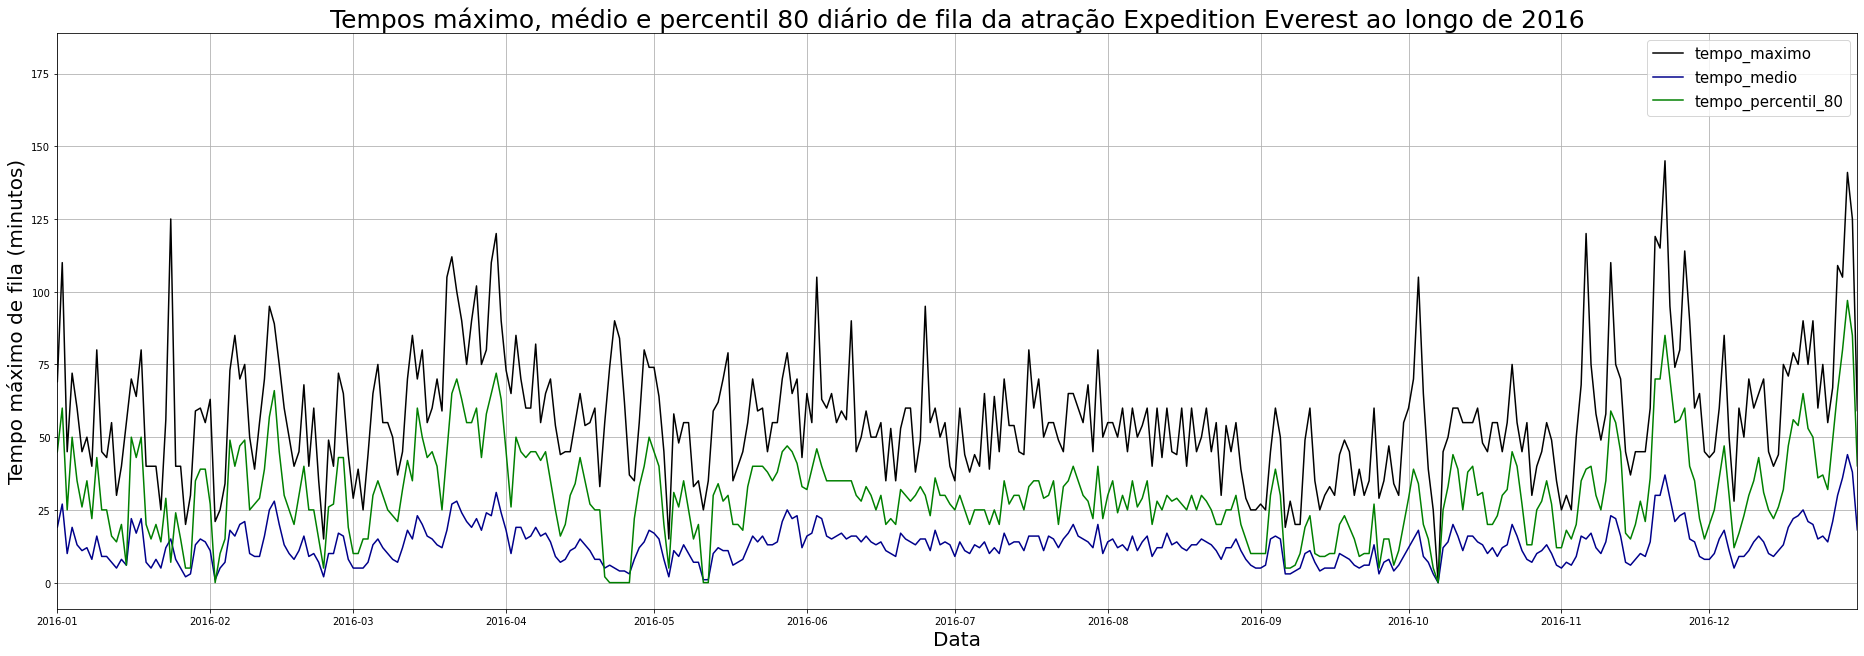

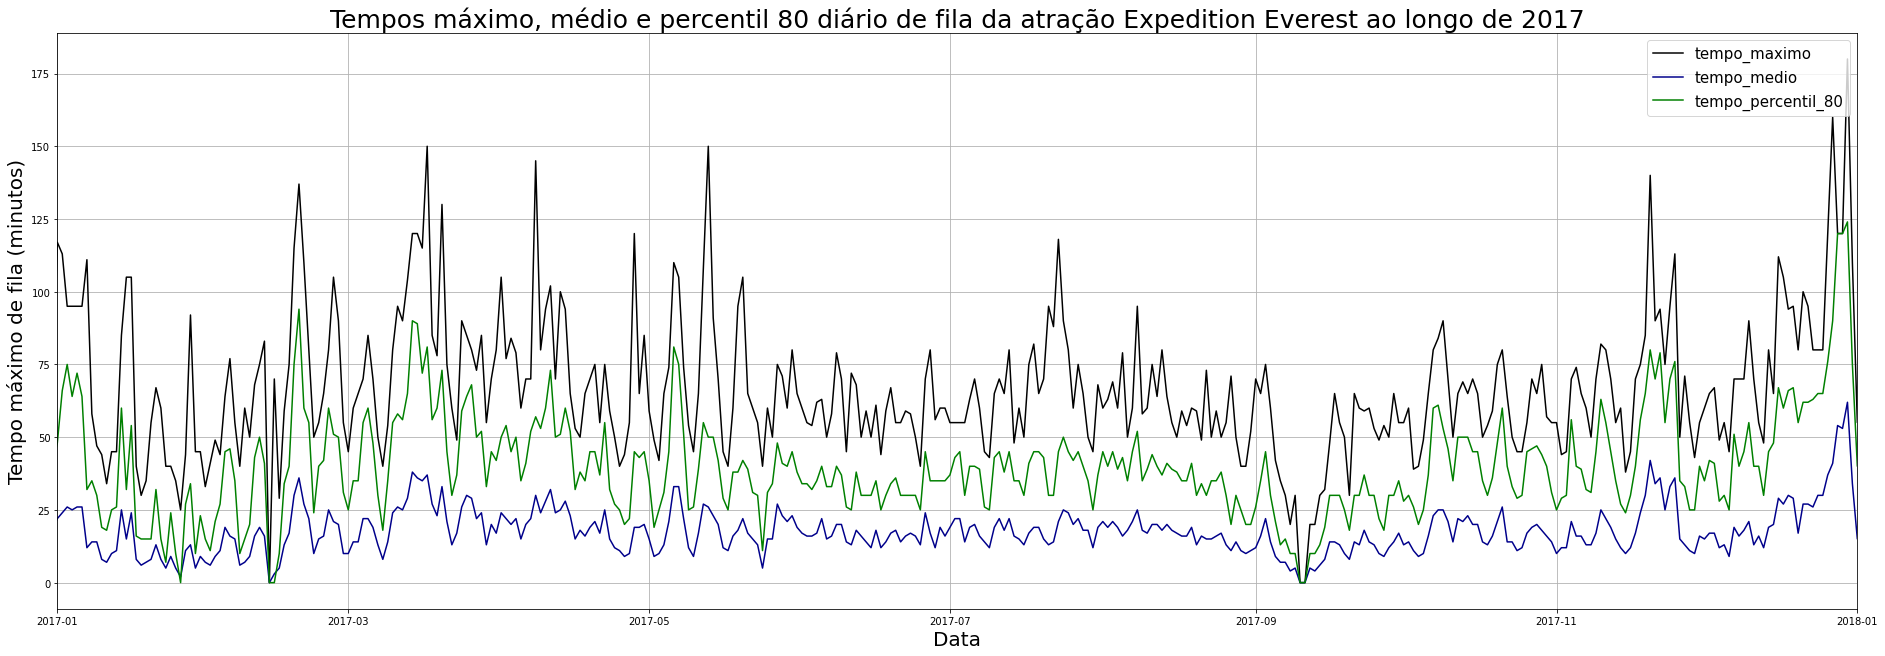

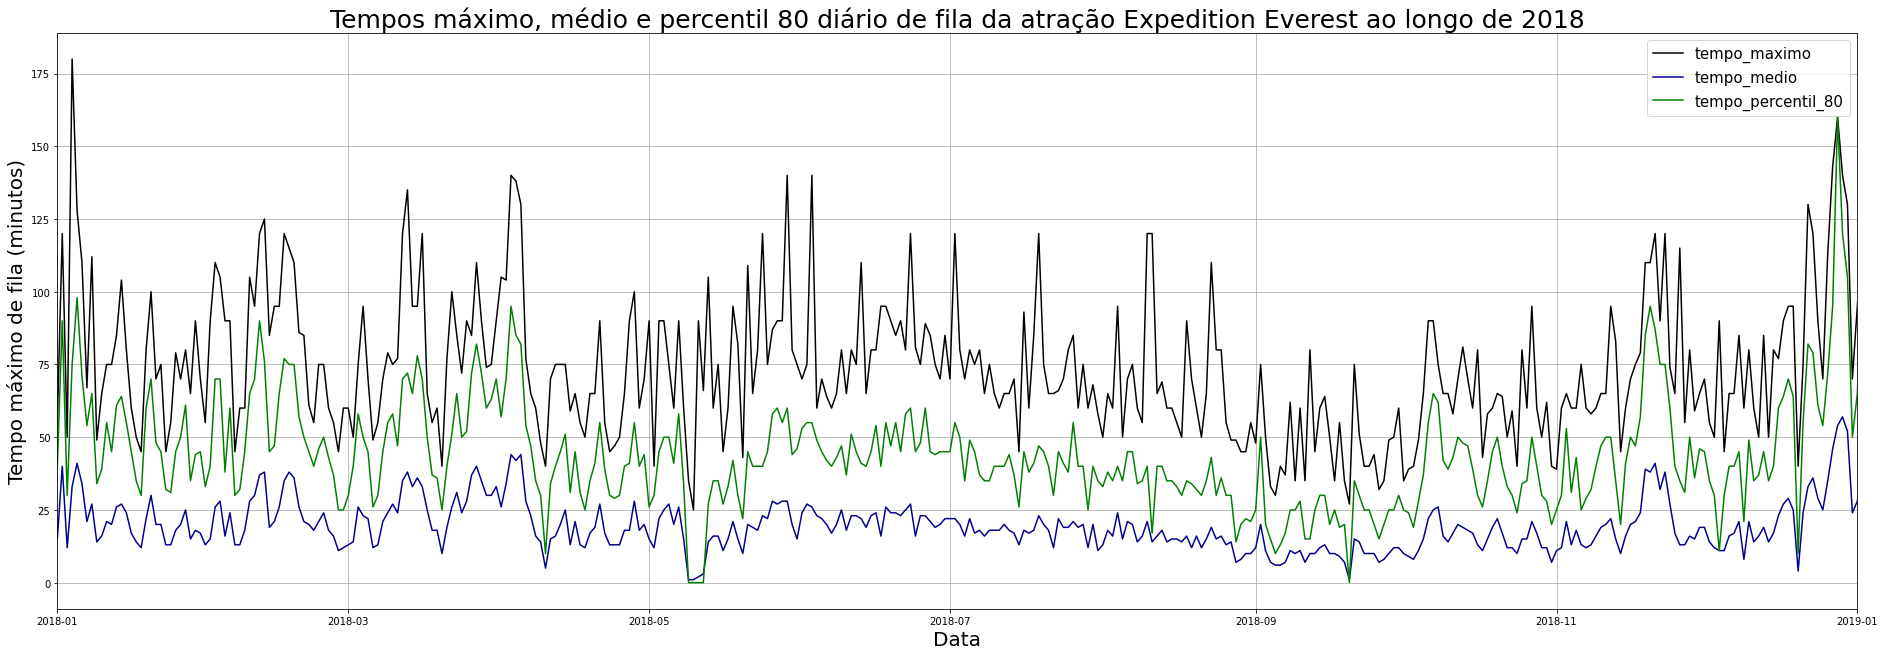

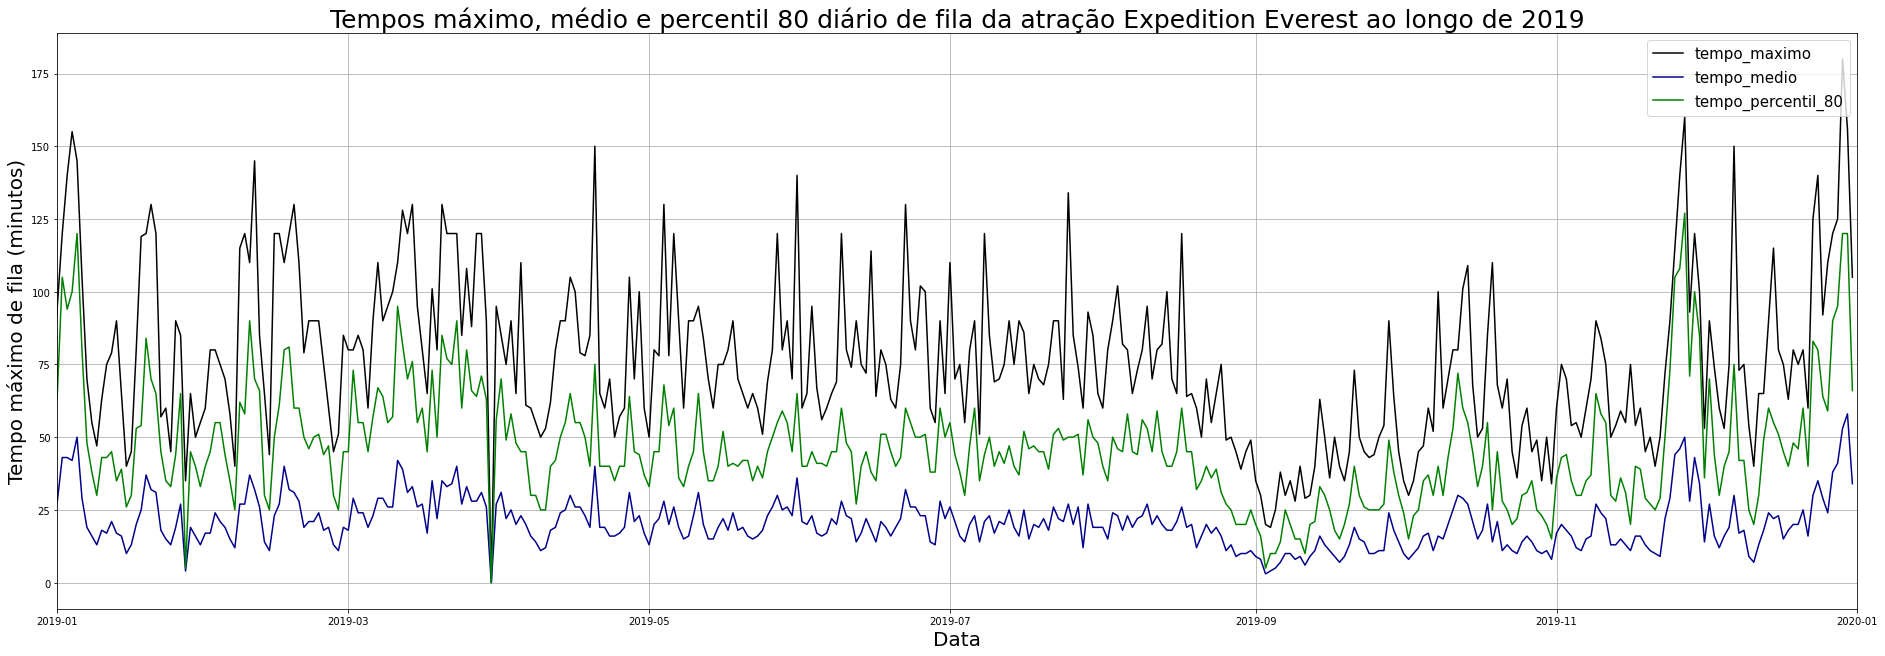

In [23]:

j = int(input('Quantas gráficos anuais você quer visualizar?'))
for j in range(1,(j+1)):
  i = int(input('Escolha uma atração: '))
  y = int(input('Escolha um ano de 2015 a 2019: '))
  
  data_inicial = datetime(y, 1, 1)
  data_final = data_inicial + timedelta(days=365)
  fig = plt.figure(figsize = (25,8))
  eixo = fig.add_axes([0, 0, 1, 1])
  eixo.plot(tempos_diarios_maximos_df[i]['data'], tempos_diarios_maximos_df[i]['tempo_maximo'], color = 'black')
  eixo.plot(tempos_diarios_medios_df[i]['data'], tempos_diarios_medios_df[i]['tempo_medio'], color = 'darkblue')
  eixo.plot(tempos_diarios_8_df[i]['data'], tempos_diarios_8_df[i]['tempo_percentil_80'], color = 'g')

  eixo.set_xlim(data_inicial,data_final)
  eixo.set_title('Tempos máximo, médio e percentil 80 diário de fila da atração {} ao longo de {}'.format(nome_das_atracoes[i], y), fontsize = 25)
  eixo.set_ylabel('Tempo máximo de fila (minutos)', fontsize = 20)
  eixo.set_xlabel('Data', fontsize = 20)
  eixo.legend([ 'tempo_maximo', 'tempo_medio', 'tempo_percentil_80'], loc = 'upper right', fontsize = 15)
  eixo.grid(True)

Conclusões: O tempo máximo não é uma boa métrica pois traduz o comportamento de um dia inteiro a um momento pontual, desconsiderando o resto do dia.

O tempo médio pode representar o comportamento do dia, uma vez que leva em consideração todos os dados de cada dia.

O tempo do percentil 80 pode representar o comportamento do dia pois é baseado numa distribuição ordenada dos valores de cada dia.  Ou seja, para o pico observado em Fevereiro de 2019 na atração 6 (Rock'n Roller Coaster), em 80% das observações, o tempo de fila era de até um pouco mais de 175 minutos.

## <font color=green>Separando os dados por parque</font>
***

In [24]:
MagicKingdom = pd.DataFrame(index = range(0,525888), 
                            columns = ['data_e_hora',
                                       nome_das_atracoes[1],
                                       nome_das_atracoes[2],
                                       nome_das_atracoes[3]])
MagicKingdom.data_e_hora = instantes_5_em_5
MagicKingdom['Splash Mountain'][:] = datasets_das_atracoes_3[1].tempo_de_fila[:]
MagicKingdom['Pirates of Caribbean'][:] = datasets_das_atracoes_3[2].tempo_de_fila[:]
MagicKingdom['Seven Dwarfs Mine Train'][:] = datasets_das_atracoes_3[3].tempo_de_fila[:]


Epcot = pd.DataFrame(index = range(0,525888), 
                            columns = ['data_e_hora',
                                       nome_das_atracoes[4],
                                       nome_das_atracoes[5]])
Epcot.data_e_hora = instantes_5_em_5
Epcot['Soarin'][:] = datasets_das_atracoes_3[4].tempo_de_fila[:]
Epcot['Spaceship Earth'][:] = datasets_das_atracoes_3[5].tempo_de_fila[:]


HollywoodStudios = pd.DataFrame(index = range(0,525888), 
                            columns = ['data_e_hora',
                                       nome_das_atracoes[6],
                                       nome_das_atracoes[7],
                                       nome_das_atracoes[8],
                                       nome_das_atracoes[9]])
HollywoodStudios.data_e_hora = instantes_5_em_5
HollywoodStudios['Rock n Roller Coaster'][:] = datasets_das_atracoes_3[6].tempo_de_fila[:]
HollywoodStudios['Slinky Dog Dash'][:] = datasets_das_atracoes_3[7].tempo_de_fila[:]
HollywoodStudios['Alien Saucers'][:] = datasets_das_atracoes_3[8].tempo_de_fila[:]
HollywoodStudios['Toy Story Mania'][:] = datasets_das_atracoes_3[9].tempo_de_fila[:]


AnimalKingdom = pd.DataFrame(index = range(0,525888), 
                            columns = ['data_e_hora',
                                       nome_das_atracoes[10],
                                       nome_das_atracoes[11],
                                       nome_das_atracoes[12],
                                       nome_das_atracoes[13],
                                       nome_das_atracoes[14]])
AnimalKingdom.data_e_hora = instantes_5_em_5
AnimalKingdom['Kilimanjaro Safari'][:] = datasets_das_atracoes_3[6].tempo_de_fila[:]
AnimalKingdom['Dinosaur'][:] = datasets_das_atracoes_3[6].tempo_de_fila[:]
AnimalKingdom['Expedition Everest'][:] = datasets_das_atracoes_3[6].tempo_de_fila[:]
AnimalKingdom['Avatar: Flight of Passage'][:] = datasets_das_atracoes_3[6].tempo_de_fila[:]
AnimalKingdom['Navi River'][:] = datasets_das_atracoes_3[6].tempo_de_fila[:]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: Setti

In [25]:
MagicKingdom

data_e_hora  ...  Seven Dwarfs Mine Train
0      2015-01-01 00:00:00  ...                      0.0
1      2015-01-01 00:05:00  ...                      0.0
2      2015-01-01 00:10:00  ...                      0.0
3      2015-01-01 00:15:00  ...                      0.0
4      2015-01-01 00:20:00  ...                      0.0
...                    ...  ...                      ...
525883 2019-12-31 23:35:00  ...                     34.0
525884 2019-12-31 23:40:00  ...                     31.0
525885 2019-12-31 23:45:00  ...                     30.0
525886 2019-12-31 23:50:00  ...                     30.0
525887 2019-12-31 23:55:00  ...                     30.0

[525888 rows x 4 columns]

In [26]:
Epcot

data_e_hora  Soarin  Spaceship Earth
0      2015-01-01 00:00:00     0.0              0.0
1      2015-01-01 00:05:00     0.0              0.0
2      2015-01-01 00:10:00     0.0              0.0
3      2015-01-01 00:15:00     0.0              0.0
4      2015-01-01 00:20:00     0.0              0.0
...                    ...     ...              ...
525883 2019-12-31 23:35:00    35.0             25.0
525884 2019-12-31 23:40:00    35.0             25.0
525885 2019-12-31 23:45:00    35.0             25.0
525886 2019-12-31 23:50:00    35.0             25.0
525887 2019-12-31 23:55:00    35.0             25.0

[525888 rows x 3 columns]

In [27]:
HollywoodStudios

data_e_hora  ...  Toy Story Mania
0      2015-01-01 00:00:00  ...              0.0
1      2015-01-01 00:05:00  ...              0.0
2      2015-01-01 00:10:00  ...              0.0
3      2015-01-01 00:15:00  ...              0.0
4      2015-01-01 00:20:00  ...              0.0
...                    ...  ...              ...
525883 2019-12-31 23:35:00  ...             16.0
525884 2019-12-31 23:40:00  ...             15.0
525885 2019-12-31 23:45:00  ...             14.0
525886 2019-12-31 23:50:00  ...              6.0
525887 2019-12-31 23:55:00  ...              0.0

[525888 rows x 5 columns]

In [28]:
AnimalKingdom

data_e_hora  ...  Navi River
0      2015-01-01 00:00:00  ...         0.0
1      2015-01-01 00:05:00  ...         0.0
2      2015-01-01 00:10:00  ...         0.0
3      2015-01-01 00:15:00  ...         0.0
4      2015-01-01 00:20:00  ...         0.0
...                    ...  ...         ...
525883 2019-12-31 23:35:00  ...        23.0
525884 2019-12-31 23:40:00  ...        12.0
525885 2019-12-31 23:45:00  ...         0.0
525886 2019-12-31 23:50:00  ...         0.0
525887 2019-12-31 23:55:00  ...         0.0

[525888 rows x 6 columns]